In [1]:
# Import libraries

import sys
import re
import requests
import asyncio
import nest_asyncio
import aiohttp
import time
import warnings
from datetime import datetime

# Suppress unnecessary Shapely warning
warnings.filterwarnings('ignore',
                        '.*Shapely GEOS version.*')

from aiohttp import ClientSession
from requests import request, Session
from itertools import product, repeat
import os
from dotenv import load_dotenv
from os import getenv
from threading import Thread
import time
import inspect
import pandas as pd
import geopandas as gp
import shapely
import pygeos
from functools import reduce
from pandas.plotting import lag_plot
import pickle
import numpy as np
import seaborn as sns
import datetime as dt
import copy
import math
from decimal import Decimal
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
import matplotlib as mpl
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from multiprocess import Process, Pool

# All helper functions are in this module:
from helper_functions.census_functions import *

# Set up Pandas defaults
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns", None)

## Get Census Key

In [2]:
# Test getting census key
print("Census key:", census_key)


Census key: f25144e3809a49b45c5cc54e7d2bce532fe4ce99


### Create the directories for file-saving

In [3]:
create_folder("datasets/cleaned_census_api_files/")
create_folder("datasets/cleaned_census_api_files/graphable/")
create_folder("datasets/cleaned_census_api_files/raw/")
create_folder("datasets/cleaned_census_api_files/standardized/")

## Following Tutorial Below
Referencing [this](https://www.youtube.com/watch?v=LW-M_UC0VTE) tutorial.

Here is the [Census API](https://www.census.gov/data/developers/data-sets.html)

## Get Population at the Tract Level

### Get Population by block group for 2013-2020

In [4]:
%%time
# Start list
df_list = []
nest_asyncio.apply()

# Start session
session = Session()

# Define our API variable
# It's within a dictionary because some variables
# can change names from year to year (but not all)
census_code_dict = {
    2013: 'B01003_001E',
    2014: 'B01003_001E',
    2015: 'B01003_001E', # No change in code number this year
    2016: 'B01003_001E',
    2017: 'B01003_001E',
    2018: 'B01003_001E',
    2019: 'B01003_001E',
    2020: 'B01003_001E',
    2021: 'B01003_001E'
}

census_code_meaning='population_blocks'

# Run the API call
asyncio.run(url_to_dataframe_async_owners(2013, 2021, 
                                          fifty_states_list=fifty_states_list,
                                          census_code_dict=census_code_dict,
                                          df_list=df_list,
                                          census_code_meaning=census_code_meaning,
                                         get_blocks=True))

# Get merged dataframe
pop_by_blocks_raw = final_data_prep(df_list, census_code_meaning, blocks=True)
pop_pre_st = merge_with_crosswalk(pop_by_blocks_raw)


Working on year: 2013 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2013/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2013 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2013/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2013,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",637.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1171.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",1383.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",972.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2366.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",1276.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",3437.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",1286.0000,72,153,750601,3,721537506013


,name,2013,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",637.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1171.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",1383.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",972.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2366.0000,01,001,020300,1,010010203001


Working on year: 2014 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2014 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2014,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",676.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1224.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",1289.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1053.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2376.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",822.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",2940.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",1612.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    676.0000
1500000US010010201002   1224.0000
1500000US010010202001   1289.0000
1500000US010010202002   1053.0000
1500000US010010203001   2376.0000
Name: 2014, dtype: float64

Working on year: 2015 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2015 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2015,state,county,tract,block group,block
geo_id,,,,,,,
1500000US060170303011,"Block Group 1, Census Tract 303.01, El Dorado ...",606.0000,06,017,030301,1,060170303011
1500000US060170303012,"Block Group 2, Census Tract 303.01, El Dorado ...",621.0000,06,017,030301,2,060170303012
1500000US060170303013,"Block Group 3, Census Tract 303.01, El Dorado ...",957.0000,06,017,030301,3,060170303013
1500000US060170303021,"Block Group 1, Census Tract 303.02, El Dorado ...",888.0000,06,017,030302,1,060170303021
1500000US060170303022,"Block Group 2, Census Tract 303.02, El Dorado ...",960.0000,06,017,030302,2,060170303022
...,...,...,...,...,...,...,...
1500000US530330263002,"Block Group 2, Census Tract 263, King County, ...",1016.0000,53,033,026300,2,530330263002
1500000US530330264001,"Block Group 1, Census Tract 264, King County, ...",699.0000,53,033,026400,1,530330264001
1500000US530330264002,"Block Group 2, Census Tract 264, King County, ...",1548.0000,53,033,026400,2,530330264002


geo_id
1500000US060170303011   606.0000
1500000US060170303012   621.0000
1500000US060170303013   957.0000
1500000US060170303021   888.0000
1500000US060170303022   960.0000
Name: 2015, dtype: float64

Working on year: 2016 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2016 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2016,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010479561001,"Block Group 1, Census Tract 9561, Dallas Count...",190.0000,01,047,956100,1,010479561001
1500000US010479561002,"Block Group 2, Census Tract 9561, Dallas Count...",1815.0000,01,047,956100,2,010479561002
1500000US010479561003,"Block Group 3, Census Tract 9561, Dallas Count...",1604.0000,01,047,956100,3,010479561003
1500000US010479561004,"Block Group 4, Census Tract 9561, Dallas Count...",2120.0000,01,047,956100,4,010479561004
1500000US010479561005,"Block Group 5, Census Tract 9561, Dallas Count...",592.0000,01,047,956100,5,010479561005
...,...,...,...,...,...,...,...
1500000US721130730023,"Block Group 3, Census Tract 730.02, Ponce Muni...",2478.0000,72,113,073002,3,721130730023
1500000US721130730031,"Block Group 1, Census Tract 730.03, Ponce Muni...",2073.0000,72,113,073003,1,721130730031
1500000US721130730041,"Block Group 1, Census Tract 730.04, Ponce Muni...",912.0000,72,113,073004,1,721130730041


geo_id
1500000US010479561001    190.0000
1500000US010479561002   1815.0000
1500000US010479561003   1604.0000
1500000US010479561004   2120.0000
1500000US010479561005    592.0000
Name: 2016, dtype: float64

Working on year: 2017 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2017 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2017,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",692.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1153.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",1020.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1152.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2555.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",740.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",2348.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",1292.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    692.0000
1500000US010010201002   1153.0000
1500000US010010202001   1020.0000
1500000US010010202002   1152.0000
1500000US010010203001   2555.0000
Name: 2017, dtype: float64

Working on year: 2018 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2018 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2018,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",636.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1287.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",810.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1218.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2641.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",699.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",2432.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",976.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    636.0000
1500000US010010201002   1287.0000
1500000US010010202001    810.0000
1500000US010010202002   1218.0000
1500000US010010203001   2641.0000
Name: 2018, dtype: float64

Working on year: 2019 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2019 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2019,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",730.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1263.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",835.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1124.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2774.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",883.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",2523.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",991.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    730.0000
1500000US010010201002   1263.0000
1500000US010010202001    835.0000
1500000US010010202002   1124.0000
1500000US010010203001   2774.0000
Name: 2019, dtype: float64

Working on year: 2020 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2020 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2020,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",674.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1267.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",706.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1051.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2912.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",1825.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",1504.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",1276.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    674.0000
1500000US010010201002   1267.0000
1500000US010010202001    706.0000
1500000US010010202002   1051.0000
1500000US010010203001   2912.0000
Name: 2020, dtype: float64

Working on year: 2021 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2021 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
Getting URL for the blocks, with no multi-code.
Get blocks? : True
Multi code? : False
URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,GEO_ID,B01003_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2021,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",693.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",1098.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",844.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1166.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",2685.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",1894.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",1820.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",1213.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    693.0000
1500000US010010201002   1098.0000
1500000US010010202001    844.0000
1500000US010010202002   1166.0000
1500000US010010203001   2685.0000
Name: 2021, dtype: float64

Completed data prep.
CPU times: user 26.5 s, sys: 3.68 s, total: 30.2 s
Wall time: 4min 28s


In [5]:
# Read in the dataframe
pop_by_blocks_raw = pd.read_csv(
    "datasets/cleaned_census_api_files/raw/population_blocks_raw.csv",
    encoding='utf-8',
    dtype={'geo_id':str, 'state':str, 'county':str, 
          'tract':str, 'block group':str, 'block':str})
pop_pre_st = merge_with_crosswalk(pop_by_blocks_raw)


#### Standardize

In [8]:
%%time
# This can and should be assigned to cloud parrallelization.
# The good thing is this function only needs to run once.
year_end = 2021
pop_dictionary = {}
array2 = pop_pre_st['BG20'].unique()

# Run the standardization function
[block_standardize(
    x, pop_dict=pop_dictionary, og_df=pop_pre_st, year_end=year_end) for x in array2]

saved_pop_dictionary = pop_dictionary.copy()

pop_standardized_df_1 = (pd.DataFrame.from_dict(saved_pop_dictionary, 
                       orient='index', 
                       columns=[str(i) for i in range(2013, year_end + 1)])
                       .reset_index()
                       .rename(columns={'index':'geoid_block'})
                      )

pop_standardized_df_1.to_csv('datasets/cleaned_census_api_files/raw/population_standardized_raw.csv',
                          encoding='utf-8',
                          index=False)

CPU times: user 10h 19min 7s, sys: 31min 38s, total: 10h 50min 45s
Wall time: 11h 5min 27s


### Final dataframe clean up

,geoid_block,geoid_tract,state,county,tract,2013_block,2014_block,2015_block,2016_block,2017_block,2018_block,2019_block,2020_block,2021_block,ratio,z_score,2013_tract,2014_tract,2015_tract,2016_tract,2017_tract,2018_tract,2019_tract,2020_tract,2021_tract
0,010010201001,01001020100,01,001,020100,637.0000,676.0000,649.0000,745.0000,692.0000,636.0000,730.0000,674.0000,693.0000,-0.0831,-0.1050,1808.0000,1900.0000,1948.0000,2010.0000,1845.0000,1923.0000,1993.0000,1941.0000,1791.0000


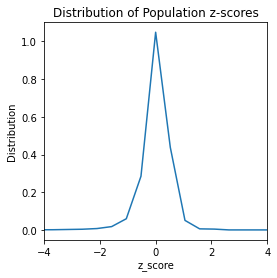

Standardized blocks:


,geoid_block,geoid_tract,state,county,tract,2013_block,2014_block,2015_block,2016_block,2017_block,2018_block,2019_block,2020_block,2021_block,ratio,z_score,geometry
0,401350302011,40135030201,40,135,030201,1733.4914,1411.9968,1447.4166,1667.4083,1538.6953,1547.0699,1675.3698,1681.0000,1492.0000,0.0033,0.0816,"POLYGON ((-95.09280 35.55430, -95.09271 35.554..."
1,401350301011,40135030101,40,135,030101,972.0000,1076.0000,866.0000,962.0000,1009.0000,987.0000,1084.0000,999.0000,984.0000,-0.0851,-0.1093,"POLYGON ((-94.88510 35.45502, -94.88508 35.455..."
2,401350301013,40135030101,40,135,030101,1670.0000,1615.0000,1705.0000,1733.0000,1796.0000,1875.0000,1988.0000,1868.0000,1830.0000,-0.0642,-0.0643,"POLYGON ((-94.88511 35.49864, -94.88507 35.499..."
3,401350304011,40135030401,40,135,030401,1755.0000,1657.0000,1795.0000,2044.0000,1986.0000,2126.0000,2186.0000,2295.0000,2058.0000,0.0475,0.1769,"POLYGON ((-94.86567 35.39050, -94.86562 35.390..."
4,401350302022,40135030202,40,135,030202,1747.3986,1715.5190,1490.3696,1459.4863,1454.5051,1494.3546,1816.1389,1524.0000,1382.0000,-0.1917,-0.3394,"POLYGON ((-95.13231 35.54575, -95.13229 35.547..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242330,320030029972,32003002997,32,003,002997,2445.0000,2052.0000,1885.0000,1808.0000,1705.0000,1700.0000,2135.0000,2216.0000,1936.0000,0.0366,0.1533,"POLYGON ((-115.27898 36.14263, -115.27898 36.1..."
242331,320030057211,32003005721,32,003,005721,1345.0000,1206.0000,1310.0000,1032.0000,1023.0000,1032.0000,1111.0000,1017.0000,923.0000,-0.0924,-0.1251,"POLYGON ((-115.11805 35.95914, -115.11789 35.9..."
242332,320030053652,32003005365,32,003,005365,1083.2042,1108.1351,1209.2696,1309.2264,1167.9967,1476.3187,1763.8788,1882.0000,2138.0000,0.0628,0.2099,"POLYGON ((-115.04734 36.01287, -115.04400 36.0..."
242333,320030058691,32003005869,32,003,005869,3451.0000,2977.0000,2986.0000,3515.0000,3882.0000,4133.0000,4233.0000,3962.0000,4069.0000,-0.0684,-0.0733,"POLYGON ((-115.30694 36.07013, -115.30635 36.0..."


Standardized tracts:


,geoid_tract,state,county,tract,2013_tract,2014_tract,2015_tract,2016_tract,2017_tract,2018_tract,2019_tract,2020_tract,2021_tract,geometry
0,50005957100,50,005,957100,2211.0799,2148.0277,2014.1457,1970.1426,2050.7323,2133.7502,2080.6299,2087.0000,2190.0000,"POLYGON ((-71.99900 44.59293, -71.99869 44.593..."
1,50005957400,50,005,957400,3734.2239,3765.7427,3689.1615,3491.7477,3493.6291,3552.8896,3536.3499,3548.0000,3668.0000,"POLYGON ((-72.08352 44.51031, -72.08252 44.510..."
2,50005957000,50,005,957000,4071.1914,4242.5148,4320.3609,4374.3472,4408.1818,4423.3748,4286.9640,4227.0000,4250.0000,"POLYGON ((-72.32168 44.46276, -72.32014 44.464..."
3,50005957700,50,005,957700,2977.8220,2969.7151,2942.8230,2926.8462,2900.9549,2891.8777,2883.0533,2873.0000,2938.0000,"POLYGON ((-72.43014 44.51166, -72.42985 44.512..."
4,50005957300,50,005,957300,3377.0000,3295.0000,3322.0000,3280.0000,3342.0000,3346.0000,3345.0000,3304.0000,3250.0000,"POLYGON ((-72.08324 44.51127, -72.08178 44.516..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85390,19099040600,19,099,040600,2953.0000,2779.0000,2846.0000,2881.0000,2948.0000,3018.0000,3182.0000,3137.0000,3268.0000,"POLYGON ((-93.07728 41.69191, -93.07727 41.692..."
85391,19099040200,19,099,040200,3649.0000,3616.0000,3500.0000,3477.0000,3552.0000,3858.0000,3956.0000,4063.0000,4147.0000,"POLYGON ((-93.34850 41.68995, -93.34849 41.693..."
85392,19195690300,19,195,690300,2911.0000,2968.0000,3081.0000,3132.0000,2924.0000,2837.0000,2702.0000,2660.0000,2618.0000,"POLYGON ((-93.27072 43.38607, -93.26936 43.386..."
85393,19195690200,19,195,690200,2224.0000,2203.0000,2198.0000,2186.0000,2203.0000,2107.0000,2156.0000,2161.0000,2165.0000,"POLYGON ((-93.49782 43.40830, -93.49776 43.408..."


/Users/WonderWolff/Real_Estate/housing_supply_and_demand/venv/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Successfully saved population_bg_geo.gpkg


/Users/WonderWolff/Real_Estate/housing_supply_and_demand/venv/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


Successfully saved population_tract_geo.gpkg


In [4]:
pop_standardized_df_1 = pd.read_csv('datasets/cleaned_census_api_files/raw/population_standardized_raw.csv',
                                  encoding='utf-8',
                                 dtype={'geoid_block':str})

# Run statistics function to get ratio and z-score
pop_standardized_df_1 = get_statistics(
    pop_standardized_df_1, begin_year=2013, end_year=2021)

# Add columns for state,county, and tract, and make sums for census tracts
pop_standardized_df_2 = specify_geographies(pop_standardized_df_1, 2013, 2021)
display(pop_standardized_df_2.head(1))

pop_standardized_df_2.to_csv('datasets/cleaned_census_api_files/standardized/population_standardized.csv',
                          encoding='utf-8',
                          index=False)

# Plot zscores to check for anomalies
plot_zscores(pop_standardized_df_2['z_score'], 'Population')

# Create the shapefiles for block groups and tracts
pop_tract_geo = create_and_save_geo_files(dataframe=pop_standardized_df_2, 
                                          name='population',
                                          begin_year=2013, 
                                          end_year=2021)



### Group Tracts By City

In [ ]:
##### Use the below function and incorporate it into the main
##### cencus helper functions. 

def group_tracts_by_city(tract_gdf, city_name, state_name):
    """
    Group tracts by a given city and save them as
    an individual dataframes.
    
    Parameters:
        tract_gdf (GeoDataFrame): The geodataframe
            you want to split by city.
        city_name (str): Name of city.
        state_name (str): Name of state.
    
    Returns:
        None.
    """
    
    # Read in the city shapefile
    city_boundaries = gp.read_file(
        "datasets/census_original_files/cities_2020/all_cities_2020/all_tracts_2020.shp")
    
    # Filter by city name and state
    
    # Make copy
    df = tract_gdf.copy()
    
    ### Below is an algorithm to only keep tracts
    ### that are within 50% or more of a city's boundary
    
    # Step 1: Calculate area of each tract
    df['tract_area'] = df.area
    
    # Step 2: Overlay the city boundaries over the tracts
    df_2 = df.overlay(city_boundaries, how="intersect")
    
    display(df_2)
    
    # Step 3: Calculate new areas
    df_2['area_']
    
group_tracts_by_city(pop_tract_geo)

In [ ]:
pop_tract_geo

In [ ]:
### Temporary code - can be deleted once file is created

# Goal: Create csv that matches states to FIPS codes



End of standardizing and merging population

---

## Median Gross Rent

Estimated Median of bin values = 𝑙 + (𝑛/2 − 𝐹)/𝑓 ⋅ 𝑤

#### Below is their "Median Value." Once we standardize, compare the values to this table below!

In [5]:
# %%time
# # Start list
# df_list = []
# nest_asyncio.apply()

# # Start session
# session = Session()

# # Define our API variable
# # It's within a dictionary because some variables
# # can change names from year to year (but not all)
# census_code_dict = {
#     2013: 'B25064_001E',
#     2014: 'B25064_001E',
#     2015: 'B25064_001E', # No change in code number this year
#     2016: 'B25064_001E',
#     2017: 'B25064_001E',
#     2018: 'B25064_001E',
#     2019: 'B25064_001E',
#     2020: 'B25064_001E',
#     2021: 'B25064_001E'
# }

# census_code_meaning='median_rent_2013_2021_blocks'

# # Run the API call
# asyncio.run(url_to_dataframe_async_owners(2013, 2021, 
#                                           fifty_states_list,
#                                           census_code_dict,
#                                           df_list=df_list,
#                                           census_code_meaning=census_code_meaning,
#                                          get_blocks=True,
#                                          ))

# # Get merged dataframe
# median_rent_raw = final_data_prep(df_list, census_code_meaning, blocks=True)



Working on year: 2013 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2013/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2013 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2013/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2013,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010150025024,"Block Group 4, Census Tract 25.02, Calhoun Cou...",-666666666.0000,01,015,002502,4,010150025024
1500000US010150026001,"Block Group 1, Census Tract 26, Calhoun County...",686.0000,01,015,002600,1,010150026001
1500000US010150026002,"Block Group 2, Census Tract 26, Calhoun County...",728.0000,01,015,002600,2,010150026002
1500000US010150026003,"Block Group 3, Census Tract 26, Calhoun County...",750.0000,01,015,002600,3,010150026003
1500000US010159819011,"Block Group 1, Census Tract 9819.01, Calhoun C...",-666666666.0000,01,015,981901,1,010159819011
...,...,...,...,...,...,...,...
1500000US721130708001,"Block Group 1, Census Tract 708, Ponce Municip...",142.0000,72,113,070800,1,721130708001
1500000US721130708002,"Block Group 2, Census Tract 708, Ponce Municip...",297.0000,72,113,070800,2,721130708002
1500000US721130709001,"Block Group 1, Census Tract 709, Ponce Municip...",294.0000,72,113,070900,1,721130709001


,name,2013,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010150025024,"Block Group 4, Census Tract 25.02, Calhoun Cou...",-666666666.0000,01,015,002502,4,010150025024
1500000US010150026001,"Block Group 1, Census Tract 26, Calhoun County...",686.0000,01,015,002600,1,010150026001
1500000US010150026002,"Block Group 2, Census Tract 26, Calhoun County...",728.0000,01,015,002600,2,010150026002
1500000US010150026003,"Block Group 3, Census Tract 26, Calhoun County...",750.0000,01,015,002600,3,010150026003
1500000US010159819011,"Block Group 1, Census Tract 9819.01, Calhoun C...",-666666666.0000,01,015,981901,1,010159819011


Working on year: 2014 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2014 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2014/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2014,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010030115021,"Block Group 1, Census Tract 115.02, Baldwin Co...",719.0000,01,003,011502,1,010030115021
1500000US010030115022,"Block Group 2, Census Tract 115.02, Baldwin Co...",488.0000,01,003,011502,2,010030115022
1500000US010030115023,"Block Group 3, Census Tract 115.02, Baldwin Co...",837.0000,01,003,011502,3,010030115023
1500000US010030115024,"Block Group 4, Census Tract 115.02, Baldwin Co...",795.0000,01,003,011502,4,010030115024
1500000US010030116011,"Block Group 1, Census Tract 116.01, Baldwin Co...",780.0000,01,003,011601,1,010030116011
...,...,...,...,...,...,...,...
1500000US721270022001,"Block Group 1, Census Tract 22, San Juan Munic...",660.0000,72,127,002200,1,721270022001
1500000US721270022002,"Block Group 2, Census Tract 22, San Juan Munic...",604.0000,72,127,002200,2,721270022002
1500000US721270023001,"Block Group 1, Census Tract 23, San Juan Munic...",433.0000,72,127,002300,1,721270023001


geo_id
1500000US010030115021   719.0000
1500000US010030115022   488.0000
1500000US010030115023   837.0000
1500000US010030115024   795.0000
1500000US010030116011   780.0000
Name: 2014, dtype: float64

Working on year: 2015 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2015 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2015,state,county,tract,block group,block
geo_id,,,,,,,
1500000US060371151031,"Block Group 1, Census Tract 1151.03, Los Angel...",1750.0000,06,037,115103,1,060371151031
1500000US060371151041,"Block Group 1, Census Tract 1151.04, Los Angel...",2659.0000,06,037,115104,1,060371151041
1500000US060371151042,"Block Group 2, Census Tract 1151.04, Los Angel...",1314.0000,06,037,115104,2,060371151042
1500000US060371152011,"Block Group 1, Census Tract 1152.01, Los Angel...",1453.0000,06,037,115201,1,060371152011
1500000US060371152012,"Block Group 2, Census Tract 1152.01, Los Angel...",1296.0000,06,037,115201,2,060371152012
...,...,...,...,...,...,...,...
1500000US360070145001,"Block Group 1, Census Tract 145, Broome County...",NaN,36,007,014500,1,360070145001
1500000US510853201001,"Block Group 1, Census Tract 3201, Hanover Coun...",NaN,51,085,320100,1,510853201001
1500000US490490102103,"Block Group 3, Census Tract 102.10, Utah Count...",NaN,49,049,010210,3,490490102103


geo_id
1500000US060371151031   1750.0000
1500000US060371151041   2659.0000
1500000US060371151042   1314.0000
1500000US060371152011   1453.0000
1500000US060371152012   1296.0000
Name: 2015, dtype: float64

Working on year: 2016 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2016 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2016,state,county,tract,block group,block
geo_id,,,,,,,
1500000US060170314063,"Block Group 3, Census Tract 314.06, El Dorado ...",-666666666.0000,06,017,031406,3,060170314063
1500000US060170314064,"Block Group 4, Census Tract 314.06, El Dorado ...",-666666666.0000,06,017,031406,4,060170314064
1500000US060170315021,"Block Group 1, Census Tract 315.02, El Dorado ...",901.0000,06,017,031502,1,060170315021
1500000US060170315022,"Block Group 2, Census Tract 315.02, El Dorado ...",1628.0000,06,017,031502,2,060170315022
1500000US060170315023,"Block Group 3, Census Tract 315.02, El Dorado ...",-666666666.0000,06,017,031502,3,060170315023
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,3,721537506013


geo_id
1500000US060170314063   -666666666.0000
1500000US060170314064   -666666666.0000
1500000US060170315021          901.0000
1500000US060170315022         1628.0000
1500000US060170315023   -666666666.0000
Name: 2016, dtype: float64

Working on year: 2017 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2017 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2017,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",594.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",870.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",589.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",952.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",973.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001   594.0000
1500000US010010201002   870.0000
1500000US010010202001   589.0000
1500000US010010202002   952.0000
1500000US010010203001   973.0000
Name: 2017, dtype: float64

Working on year: 2018 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2018 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2018,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",770.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",863.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",604.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1059.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",997.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    770.0000
1500000US010010201002    863.0000
1500000US010010202001    604.0000
1500000US010010202002   1059.0000
1500000US010010203001    997.0000
Name: 2018, dtype: float64

Working on year: 2019 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2019 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2019,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",779.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",738.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",595.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",1067.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",964.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",528.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    779.0000
1500000US010010201002    738.0000
1500000US010010202001    595.0000
1500000US010010202002   1067.0000
1500000US010010203001    964.0000
Name: 2019, dtype: float64

Working on year: 2020 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2020 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2020,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",806.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",914.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",776.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",950.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",998.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",545.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001   806.0000
1500000US010010201002   914.0000
1500000US010010202001   776.0000
1500000US010010202002   950.0000
1500000US010010203001   998.0000
Name: 2020, dtype: float64

Working on year: 2021 and states:
 01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Working on year: 2021 and states:
 27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72
URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,GEO_ID,B25064_001E&for=block%20group:*&in=state:27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,53,54,55,56,72&in=county:*&in=tract:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99


,name,2021,state,county,tract,block group,block
geo_id,,,,,,,
1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",840.0000,01,001,020100,1,010010201001
1500000US010010201002,"Block Group 2, Census Tract 201, Autauga Count...",715.0000,01,001,020100,2,010010201002
1500000US010010202001,"Block Group 1, Census Tract 202, Autauga Count...",1593.0000,01,001,020200,1,010010202001
1500000US010010202002,"Block Group 2, Census Tract 202, Autauga Count...",887.0000,01,001,020200,2,010010202002
1500000US010010203001,"Block Group 1, Census Tract 203, Autauga Count...",926.0000,01,001,020300,1,010010203001
...,...,...,...,...,...,...,...
1500000US721537506011,"Block Group 1, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,1,721537506011
1500000US721537506012,"Block Group 2, Census Tract 7506.01, Yauco Mun...",595.0000,72,153,750601,2,721537506012
1500000US721537506013,"Block Group 3, Census Tract 7506.01, Yauco Mun...",-666666666.0000,72,153,750601,3,721537506013


geo_id
1500000US010010201001    840.0000
1500000US010010201002    715.0000
1500000US010010202001   1593.0000
1500000US010010202002    887.0000
1500000US010010203001    926.0000
Name: 2021, dtype: float64

Completed data prep.
CPU times: user 28.3 s, sys: 4.08 s, total: 32.4 s
Wall time: 4min 45s


In [7]:
median_rent_raw = pd.read_csv('datasets/cleaned_census_api_files/raw/median_rent_2013_2021_blocks_raw.csv',
                                   encoding='utf-8',
                                   dtype={'geo_id':str, 'state':str, 'county':str, 
                                          'tract':str, 'block group':str, 'block':str})
median_rent_raw['block'] = median_rent_raw['geo_id'].apply(lambda x: str(x)[-12:])

spot_check(median_rent_raw, 2013, 2021)

median_rent_raw.head(1)


How many states: 52 

Null values in 2013: 68768
Null values in 2014: 68768
Null values in 2015: 74707
Null values in 2016: 68768
Null values in 2017: 68768
Null values in 2018: 68768
Null values in 2019: 68768
Null values in 2020: 46766
Null values in 2021: 46766


2021 and 2013 null values: 14
2021 and 2014 null values: 14
2021 and 2015 null values: 1481
2021 and 2016 null values: 18
2021 and 2017 null values: 18
2021 and 2018 null values: 18
2021 and 2019 null values: 18
2021 and 2020 null values: 46766


Stats for year 2013:
 count       220333.0000
mean    -114937362.4017
std      251823592.0028
min     -666666666.0000
25%            525.0000
50%            774.0000
75%           1076.0000
max           2001.0000
Name: 2013, dtype: float64 

Stats for year 2014:
 count       220333.0000
mean    -108138538.5176
std      245762544.4233
min     -666666666.0000
25%            548.0000
50%            793.0000
75%           1101.0000
max           2001.0000
Name: 2014, dtype: float64 



,geo_id,name,2013,state,county,tract,block group,block,2014,2015,2016,2017,2018,2019,2020,2021
0,1500000US010010201001,"Block Group 1, Census Tract 201, Autauga Count...",535.0000,01,001,01001020100,1,010010201001,543.0000,753.0000,579.0000,594.0000,770.0000,779.0000,806.0000,840.0000


#### Get Gross Rent for each category, then combine them! Try to get all codes for all years

In [9]:
# Get the Gross Rent Code for each year
rent_code_list = []
for i in range(3, 27):
    if i < 10:
        i = '0' + str(i)
    rent_code_list.append(f'B25063_0{i}E')
    
rent_code_list

['B25063_003E',
 'B25063_004E',
 'B25063_005E',
 'B25063_006E',
 'B25063_007E',
 'B25063_008E',
 'B25063_009E',
 'B25063_010E',
 'B25063_011E',
 'B25063_012E',
 'B25063_013E',
 'B25063_014E',
 'B25063_015E',
 'B25063_016E',
 'B25063_017E',
 'B25063_018E',
 'B25063_019E',
 'B25063_020E',
 'B25063_021E',
 'B25063_022E',
 'B25063_023E',
 'B25063_024E',
 'B25063_025E',
 'B25063_026E']

In [12]:
# %%time
# # Start list
# df_list = []
# nest_asyncio.apply()

# # Start session
# session = Session()

# # Define our API variable
# # It's within a dictionary because some variables
# # can change names from year to year (but not all)
# rent_code_list = []
# for i in range(3, 27):
#     if i < 10:
#         i = '0' + str(i)
#     rent_code_list.append(f'B25063_0{i}E')
    
# census_code_dict = {
#     2013: rent_code_list[:-3],
#     2014: rent_code_list[:-3],
#     2015: rent_code_list, 
#     2016: rent_code_list,
#     2017: rent_code_list,
#     2018: rent_code_list,
#     2019: rent_code_list,
#     2020: rent_code_list,
#     2021: rent_code_list
# }

# code_name_dict = {
#     'B25063_003E': 'rent_less_than_100',
#     'B25063_004E': 'rent_100_to_149',
#     'B25063_005E': 'rent_150_to_199',
#     'B25063_006E': 'rent_200_to_249',
#     'B25063_007E': 'rent_250_to_299',
#     'B25063_008E': 'rent_300_to_349',
#     'B25063_009E': 'rent_350_to_399',
#     'B25063_010E': 'rent_400_to_449',
#     'B25063_011E': 'rent_450_to_499',
#     'B25063_012E': 'rent_500_to_549',
#     'B25063_013E': 'rent_550_to_599',
#     'B25063_014E': 'rent_600_to_649',
#     'B25063_015E': 'rent_650_to_699',
#     'B25063_016E': 'rent_700_to_749',
#     'B25063_017E': 'rent_750_to_799',
#     'B25063_018E': 'rent_800_to_899',
#     'B25063_019E': 'rent_900_to_999',
#     'B25063_020E': 'rent_1000_to_1249',
#     'B25063_021E': 'rent_1250_to_1449',
#     'B25063_022E': 'rent_1500_to_1999',
#     'B25063_023E': 'rent_2000_to_2499',
#     'B25063_024E': 'rent_2500_to_2999',
#     'B25063_025E': 'rent_3000_to_3499',
#     'B25063_026E': 'rent_3500_or_more',
# }

# census_code_meaning='rent_distribution_blocks'

# # Run the API call
# asyncio.run(url_to_dataframe_async_owners(2013, 2021, 
#                                           fifty_states_list,
#                                           census_code_dict,
#                                           df_list=df_list,
#                                           census_code_meaning=census_code_meaning,
#                                          get_blocks=True,
#                                          multi_code=True,
#                                          code_name_dict=code_name_dict
#                                          ))

# # Get merged dataframe
# rent_distribution = final_data_prep(df_list, census_code_meaning, blocks=True)
# rent_dist_pre_st = merge_with_crosswalk(rent_dist)


In [13]:
# # Custom spot checking
# print("How many states:", len(rent_dist['state'].value_counts()), "\n")

# for code in code_name_dict:
    
#     name = code_name_dict[code]
    
#     print(f"Values for {name}")
    
#     if (name != 'rent_2500_to_2999') and (name != 'rent_3000_to_3499') and (name != 'rent_3500_or_more'):
        
#         # Check for null values
#         for i in range(2013, 2021):
#             print(f"{name} Null values in {i}:", rent_dist[rent_dist[f'{i}_{name}'].isnull()].shape[0])
#         print("\n")

#         # Check for null values in multiple years
#         for i in range(2013, 2020):
#             print(f"2020 and {i} {name} null values:", rent_dist[(rent_dist[f'2020_{name}'].isnull()) & (rent_dist[f'{i}_{name}'].isnull())].shape[0])
#         print("\n")

#         # Check stats
#         for i in range(2013, 2021):
#             print(f"{name} Stats for year {i}:\n", rent_dist[f'{i}_{name}'].describe(), "\n")
            
#     else:
        
#         # Check for null values
#         for i in range(2015, 2021):
#             print(f"{name} Null values in {i}:", rent_dist[rent_dist[f'{i}_{name}'].isnull()].shape[0])
#         print("\n")

#         # Check for null values in multiple years
#         for i in range(2015, 2020):
#             print(f"2020 and {i} {name} null values:", rent_dist[(rent_dist[f'2020_{name}'].isnull()) & (rent_dist[f'{i}_{name}'].isnull())].shape[0])
#         print("\n")

#         # Check stats
#         for i in range(2015, 2021):
#             print(f"{name} Stats for year {i}:\n", rent_dist[f'{i}_{name}'].describe(), "\n")
        

How many states: 52 

Values for rent_less_than_100
rent_less_than_100 Null values in 2013: 68768
rent_less_than_100 Null values in 2014: 68768
rent_less_than_100 Null values in 2015: 68768
rent_less_than_100 Null values in 2016: 68768
rent_less_than_100 Null values in 2017: 68768
rent_less_than_100 Null values in 2018: 68768
rent_less_than_100 Null values in 2019: 68768
rent_less_than_100 Null values in 2020: 46766


2020 and 2013 rent_less_than_100 null values: 14
2020 and 2014 rent_less_than_100 null values: 14
2020 and 2015 rent_less_than_100 null values: 18
2020 and 2016 rent_less_than_100 null values: 18
2020 and 2017 rent_less_than_100 null values: 18
2020 and 2018 rent_less_than_100 null values: 18
2020 and 2019 rent_less_than_100 null values: 18


rent_less_than_100 Stats for year 2013:
 count   220333.0000
mean         0.7325
std          6.0981
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        337.0000
Name: 2013_rent_less_than_100, d

rent_200_to_249 Null values in 2018: 68768
rent_200_to_249 Null values in 2019: 68768
rent_200_to_249 Null values in 2020: 46766


2020 and 2013 rent_200_to_249 null values: 14
2020 and 2014 rent_200_to_249 null values: 14
2020 and 2015 rent_200_to_249 null values: 18
2020 and 2016 rent_200_to_249 null values: 18
2020 and 2017 rent_200_to_249 null values: 18
2020 and 2018 rent_200_to_249 null values: 18
2020 and 2019 rent_200_to_249 null values: 18


rent_200_to_249 Stats for year 2013:
 count   220333.0000
mean         3.1404
std         12.8334
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        497.0000
Name: 2013_rent_200_to_249, dtype: float64 

rent_200_to_249 Stats for year 2014:
 count   220333.0000
mean         3.1280
std         12.8591
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        547.0000
Name: 2014_rent_200_to_249, dtype: float64 

rent_200_to_249 Stats for year 2015:
 count   220333.0000
m

rent_350_to_399 Stats for year 2013:
 count   220333.0000
mean         2.8506
std          9.1511
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        239.0000
Name: 2013_rent_350_to_399, dtype: float64 

rent_350_to_399 Stats for year 2014:
 count   220333.0000
mean         2.7950
std          9.1399
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        326.0000
Name: 2014_rent_350_to_399, dtype: float64 

rent_350_to_399 Stats for year 2015:
 count   220333.0000
mean         2.7985
std          9.1384
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        301.0000
Name: 2015_rent_350_to_399, dtype: float64 

rent_350_to_399 Stats for year 2016:
 count   220333.0000
mean         2.7479
std          9.1445
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        342.0000
Name: 2016_rent_350_to_399, dtype: float64 

rent_350_to_399 Stats for ye

rent_550_to_599 Null values in 2014: 68768
rent_550_to_599 Null values in 2015: 68768
rent_550_to_599 Null values in 2016: 68768
rent_550_to_599 Null values in 2017: 68768
rent_550_to_599 Null values in 2018: 68768
rent_550_to_599 Null values in 2019: 68768
rent_550_to_599 Null values in 2020: 46766


2020 and 2013 rent_550_to_599 null values: 14
2020 and 2014 rent_550_to_599 null values: 14
2020 and 2015 rent_550_to_599 null values: 18
2020 and 2016 rent_550_to_599 null values: 18
2020 and 2017 rent_550_to_599 null values: 18
2020 and 2018 rent_550_to_599 null values: 18
2020 and 2019 rent_550_to_599 null values: 18


rent_550_to_599 Stats for year 2013:
 count   220333.0000
mean         6.9332
std         16.7170
min          0.0000
25%          0.0000
50%          0.0000
75%          7.0000
max        359.0000
Name: 2013_rent_550_to_599, dtype: float64 

rent_550_to_599 Stats for year 2014:
 count   220333.0000
mean         6.7222
std         16.3018
min          0.0000
25%         

rent_700_to_749 Stats for year 2018:
 count   220333.0000
mean         7.7927
std         18.0818
min          0.0000
25%          0.0000
50%          0.0000
75%          8.0000
max        507.0000
Name: 2018_rent_700_to_749, dtype: float64 

rent_700_to_749 Stats for year 2019:
 count   220333.0000
mean         7.2056
std         17.2951
min          0.0000
25%          0.0000
50%          0.0000
75%          7.0000
max        399.0000
Name: 2019_rent_700_to_749, dtype: float64 

rent_700_to_749 Stats for year 2020:
 count   242335.0000
mean         6.2387
std         17.4254
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max        619.0000
Name: 2020_rent_700_to_749, dtype: float64 

Values for rent_750_to_799
rent_750_to_799 Null values in 2013: 68768
rent_750_to_799 Null values in 2014: 68768
rent_750_to_799 Null values in 2015: 68768
rent_750_to_799 Null values in 2016: 68768
rent_750_to_799 Null values in 2017: 68768
rent_750_to_799 Null values i

rent_1000_to_1249 Null values in 2015: 68768
rent_1000_to_1249 Null values in 2016: 68768
rent_1000_to_1249 Null values in 2017: 68768
rent_1000_to_1249 Null values in 2018: 68768
rent_1000_to_1249 Null values in 2019: 68768
rent_1000_to_1249 Null values in 2020: 46766


2020 and 2013 rent_1000_to_1249 null values: 14
2020 and 2014 rent_1000_to_1249 null values: 14
2020 and 2015 rent_1000_to_1249 null values: 18
2020 and 2016 rent_1000_to_1249 null values: 18
2020 and 2017 rent_1000_to_1249 null values: 18
2020 and 2018 rent_1000_to_1249 null values: 18
2020 and 2019 rent_1000_to_1249 null values: 18


rent_1000_to_1249 Stats for year 2013:
 count   220333.0000
mean        28.7264
std         51.0507
min          0.0000
25%          0.0000
50%          9.0000
75%         37.0000
max       1452.0000
Name: 2013_rent_1000_to_1249, dtype: float64 

rent_1000_to_1249 Stats for year 2014:
 count   220333.0000
mean        29.9237
std         52.4787
min          0.0000
25%          0.0000
50%

rent_2000_to_2499 Null values in 2018: 68768
rent_2000_to_2499 Null values in 2019: 68768
rent_2000_to_2499 Null values in 2020: 46766


2020 and 2013 rent_2000_to_2499 null values: 14
2020 and 2014 rent_2000_to_2499 null values: 14
2020 and 2015 rent_2000_to_2499 null values: 18
2020 and 2016 rent_2000_to_2499 null values: 18
2020 and 2017 rent_2000_to_2499 null values: 18
2020 and 2018 rent_2000_to_2499 null values: 18
2020 and 2019 rent_2000_to_2499 null values: 18


rent_2000_to_2499 Stats for year 2013:
 count   220333.0000
mean         9.8706
std         38.2496
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       3323.0000
Name: 2013_rent_2000_to_2499, dtype: float64 

rent_2000_to_2499 Stats for year 2014:
 count   220333.0000
mean        10.8514
std         41.5003
min          0.0000
25%          0.0000
50%          0.0000
75%          0.0000
max       3519.0000
Name: 2014_rent_2000_to_2499, dtype: float64 

rent_2000_to_2499 Stats for yea

In [15]:
rent_dist = pd.read_csv('datasets/cleaned_census_api_files/raw/rent_distribution_blocks_raw.csv',
                        encoding='utf-8',
                       dtype={'geo_id':str, 'state':str, 'county':str, 
                                          'tract':str, 'block group':str, 'block':str})
rent_dist_pre_st = merge_with_crosswalk(rent_dist)
rent_dist_pre_st.head(1)

,geo_id,name,2013_rent_less_than_100,2013_rent_100_to_149,2013_rent_150_to_199,2013_rent_200_to_249,2013_rent_250_to_299,2013_rent_300_to_349,2013_rent_350_to_399,2013_rent_400_to_449,2013_rent_450_to_499,2013_rent_500_to_549,2013_rent_550_to_599,2013_rent_600_to_649,2013_rent_650_to_699,2013_rent_700_to_749,2013_rent_750_to_799,2013_rent_800_to_899,2013_rent_900_to_999,2013_rent_1000_to_1249,2013_rent_1250_to_1449,2013_rent_1500_to_1999,2013_rent_2000_to_2499,state,county,tract,block group,block,2014_rent_less_than_100,2014_rent_100_to_149,2014_rent_150_to_199,2014_rent_200_to_249,2014_rent_250_to_299,2014_rent_300_to_349,2014_rent_350_to_399,2014_rent_400_to_449,2014_rent_450_to_499,2014_rent_500_to_549,2014_rent_550_to_599,2014_rent_600_to_649,2014_rent_650_to_699,2014_rent_700_to_749,2014_rent_750_to_799,2014_rent_800_to_899,2014_rent_900_to_999,2014_rent_1000_to_1249,2014_rent_1250_to_1449,2014_rent_1500_to_1999,2014_rent_2000_to_2499,2015_rent_less_than_100,2015_rent_100_to_149,2015_rent_150_to_199,2015_rent_200_to_249,2015_rent_250_to_299,2015_rent_300_to_349,2015_rent_350_to_399,2015_rent_400_to_449,2015_rent_450_to_499,2015_rent_500_to_549,2015_rent_550_to_599,2015_rent_600_to_649,2015_rent_650_to_699,2015_rent_700_to_749,2015_rent_750_to_799,2015_rent_800_to_899,2015_rent_900_to_999,2015_rent_1000_to_1249,2015_rent_1250_to_1449,2015_rent_1500_to_1999,2015_rent_2000_to_2499,2015_rent_2500_to_2999,2015_rent_3000_to_3499,2015_rent_3500_or_more,2016_rent_less_than_100,2016_rent_100_to_149,2016_rent_150_to_199,2016_rent_200_to_249,2016_rent_250_to_299,2016_rent_300_to_349,2016_rent_350_to_399,2016_rent_400_to_449,2016_rent_450_to_499,2016_rent_500_to_549,2016_rent_550_to_599,2016_rent_600_to_649,2016_rent_650_to_699,2016_rent_700_to_749,2016_rent_750_to_799,2016_rent_800_to_899,2016_rent_900_to_999,2016_rent_1000_to_1249,2016_rent_1250_to_1449,2016_rent_1500_to_1999,2016_rent_2000_to_2499,2016_rent_2500_to_2999,2016_rent_3000_to_3499,2016_rent_3500_or_more,2017_rent_less_than_100,2017_rent_100_to_149,2017_rent_150_to_199,2017_rent_200_to_249,2017_rent_250_to_299,2017_rent_300_to_349,2017_rent_350_to_399,2017_rent_400_to_449,2017_rent_450_to_499,2017_rent_500_to_549,2017_rent_550_to_599,2017_rent_600_to_649,2017_rent_650_to_699,2017_rent_700_to_749,2017_rent_750_to_799,2017_rent_800_to_899,2017_rent_900_to_999,2017_rent_1000_to_1249,2017_rent_1250_to_1449,2017_rent_1500_to_1999,2017_rent_2000_to_2499,2017_rent_2500_to_2999,2017_rent_3000_to_3499,2017_rent_3500_or_more,2018_rent_less_than_100,2018_rent_100_to_149,2018_rent_150_to_199,2018_rent_200_to_249,2018_rent_250_to_299,2018_rent_300_to_349,2018_rent_350_to_399,2018_rent_400_to_449,2018_rent_450_to_499,2018_rent_500_to_549,2018_rent_550_to_599,2018_rent_600_to_649,2018_rent_650_to_699,2018_rent_700_to_749,2018_rent_750_to_799,2018_rent_800_to_899,2018_rent_900_to_999,2018_rent_1000_to_1249,2018_rent_1250_to_1449,2018_rent_1500_to_1999,2018_rent_2000_to_2499,2018_rent_2500_to_2999,2018_rent_3000_to_3499,2018_rent_3500_or_more,2019_rent_less_than_100,2019_rent_100_to_149,2019_rent_150_to_199,2019_rent_200_to_249,2019_rent_250_to_299,2019_rent_300_to_349,2019_rent_350_to_399,2019_rent_400_to_449,2019_rent_450_to_499,2019_rent_500_to_549,2019_rent_550_to_599,2019_rent_600_to_649,2019_rent_650_to_699,2019_rent_700_to_749,2019_rent_750_to_799,2019_rent_800_to_899,2019_rent_900_to_999,2019_rent_1000_to_1249,2019_rent_1250_to_1449,2019_rent_1500_to_1999,2019_rent_2000_to_2499,2019_rent_2500_to_2999,2019_rent_3000_to_3499,2019_rent_3500_or_more,2020_rent_less_than_100,2020_rent_100_to_149,2020_rent_150_to_199,2020_rent_200_to_249,2020_rent_250_to_299,2020_rent_300_to_349,2020_rent_350_to_399,2020_rent_400_to_449,2020_rent_450_to_499,2020_rent_500_to_549,2020_rent_550_to_599,2020_rent_600_to_649,2020_rent_650_to_699,2020_rent_700_to_749,2020_rent_750_to_799,2020_rent_800_to_899,2020_rent_900_to_999,2020_rent_1000_to_1249,2020_rent_1250_to_1449,2020_rent_1500_to_1999,2020_rent_20

In [17]:
def block_standardize_medians_3(bg20_df,
                            og_df,
                            year_start,
                            year_end,
                            weight,
                            code_name_dict_2013_2014=False,
                            code_name_dict_2015_2021=False,
                            code_name_dict_all=False):

    """
    WARNING: This function alone takes a few seconds to complete
    per block group, but to standard all 242,333 block groups
    can take many, many hours to run.
    It would be wise to run this function on any type of
    parrallel processing, such as using Dask, or a GPU,
    or parrallelized cloud computing, as there is no
    serialization (the block groups can be standardized
    in no particular order).
    
    This function standardizes all block group rows. It 
    should be called in a loop or vectorized if possible,
    such as the example below. (Note, the example below
    may not be the most efficient way to loop through
    or vectorize the block groups.)
    
    ```
    # Loop through all population block groups
    # and standardize them
    pop_dictionary = {}
    array2 = pop_pre_st['BG20'].unique()
    [block_standardize(
            x, 
            pop_dict=pop_dictionary, 
            og_df=pop_pre_st) 
        for x in array2]
    ```
    
    Parameters:
        tuple (tuple): A tuple containing the below.
            block (str): The block_group to group by.
            og_df (DataFrame): The dataframe we are 
                standardizing from.
            year_start (int): Which year to start from.
            year_end (int): Which year to end from.
            weight (str): Which weight to use (such as 
                'wt_pop' pr 'wt_hh').
    
    Returns:
        None. However, it appends the standardized values
            per block group to a pre-defined dictionary.
    """

    block = bg20_df['BG20'].iloc[0]
        
    # Step 1: Get a dataframe grouped by BG20
    bg20_df = bg20_df.drop_duplicates()
    bg20_df = bg20_df.fillna(0)
    filtered = og_df[og_df['block']==block].copy().drop_duplicates()
    
    # make sure the final dict is in the form of {block : dots}
    return_array = np.array([])
    
    if code_name_dict_all == False:
    
        # Step 2: Loop through the code names that 2013 and 2014 are guaranteed to have
        for code in code_name_dict_2013_2014:

            rent_category = code_name_dict_2013_2014[code]
            years_13_19 = [f"{i}_{rent_category}" for i in range(2013, 2020)]

            # Step 3: Get dot product of 2013-2019 values with the target weight values values
            array_13_19 = bg20_df[years_13_19].to_numpy().T
            wt_array = bg20_df[weight].to_numpy()
            dots = array_13_19.dot(wt_array)

            # Step 4: Append standardized 2013-2019 and 
            # the block's 2020+ values to new dictionary
            val_20s = filtered[[
                f"{i}_{rent_category}" for i in 
                range(2020, year_end + 1)]].iloc[0].to_numpy()
            
            # If the 2020 value is 0, then all years
            # before then should be 0 also
            if val_20s[0] == 0:
                dots = dots * 0

            # val_20 = filtered[f'2020_{rent_category}'].iloc[0]
            
            # Finalize the append
            dots = np.append(dots, val_20s)

            # Save a copy of the array
            set_dots = dots.copy()

            # Update return_dictionary
            return_array = np.append(return_array, set_dots)

        # Step 2: Loop through the code names that 2013 and 2014 won't have
        for code in code_name_dict_2015_2021:

            rent_category = code_name_dict_2015_2021[code]
            years_15_19 = [f"{i}_{rent_category}" for i in range(2015, 2020)]

            # Step 3: Get dot product of 2015-2019 values with the target weight values values
            array_15_19 = bg20_df[years_15_19].to_numpy().T
            wt_array = bg20_df[weight].to_numpy()
            dots = array_15_19.dot(wt_array)
            
            # Step 4: Append standardized 2013-2019 and 
            # the block's 2020+ values to new dictionary
            val_20s = filtered[[
                f"{i}_{rent_category}" for i in 
                range(2020, year_end + 1)]].iloc[0].to_numpy()
            
            # If the 2020 value is 0, then all years
            # before then should be 0 also
            if val_20s[0] == 0:
                dots = dots * 0
            
            # Finalize the append
            dots = np.append(dots, val_20s)

            # Save a copy of the array
            set_dots = dots.copy()

            # Update return_dictionary
            return_array = np.append(return_array, set_dots)
            
    else: # if code_name_dict_all exists
        for code in code_name_dict_all:

            rent_category = code_name_dict_all[code]
            years_13_19 = [f"{i}_{rent_category}" for i in range(2013, 2020)]

            # Step 3: Get dot product of 2010-2019 values with the target weight values values
            array_13_19 = bg20_df[years_13_19].to_numpy().T
            wt_array = bg20_df[weight].to_numpy()
            dots = array_13_19.dot(wt_array)
            
            # Step 4: Append standardized 2013-2019 and 
            # the block's 2020+ values to new dictionary
            val_20s = filtered[[
                f"{i}_{rent_category}" for i in 
                range(2020, year_end + 1)]].iloc[0].to_numpy()
            
            # If the 2020 value is 0, then all years
            # before then should be 0 also
            if val_20s[0] == 0:
                dots = dots * 0

            # Finalize the append
            dots = np.append(dots, val_20s)

            # Save a copy of the array
            set_dots = dots.copy()

            # Update return_dictionary
            return_array = np.append(return_array, set_dots)
        
    return {block : return_array}

In [18]:
%%time
# Using list comprehension

begin_year = 2013
end_year = 2021

my_groups = rent_dist_pre_st.groupby('BG20')
keys = list(my_groups.groups.keys())

code_name_dict_2013_2014 = {
    'B25063_003E': 'rent_less_than_100',
    'B25063_004E': 'rent_100_to_149',
    'B25063_005E': 'rent_150_to_199',
    'B25063_006E': 'rent_200_to_249',
    'B25063_007E': 'rent_250_to_299',
    'B25063_008E': 'rent_300_to_349',
    'B25063_009E': 'rent_350_to_399',
    'B25063_010E': 'rent_400_to_449',
    'B25063_011E': 'rent_450_to_499',
    'B25063_012E': 'rent_500_to_549',
    'B25063_013E': 'rent_550_to_599',
    'B25063_014E': 'rent_600_to_649',
    'B25063_015E': 'rent_650_to_699',
    'B25063_016E': 'rent_700_to_749',
    'B25063_017E': 'rent_750_to_799',
    'B25063_018E': 'rent_800_to_899',
    'B25063_019E': 'rent_900_to_999',
    'B25063_020E': 'rent_1000_to_1249',
    'B25063_021E': 'rent_1250_to_1449',
    'B25063_022E': 'rent_1500_to_1999',
    'B25063_023E': 'rent_2000_to_2499'
}

code_name_dict_2015_2021 = {
    'B25063_024E': 'rent_2500_to_2999',
    'B25063_025E': 'rent_3000_to_3499',
    'B25063_026E': 'rent_3500_or_more'
}

dict2 = {}
dict3 = [block_standardize_medians_3(my_groups.get_group(keys[i]), 
                                rent_dist_pre_st, 
                                begin_year, 
                                end_year, 
                                'wt_hh', 
                                code_name_dict_2013_2014=code_name_dict_2013_2014, 
                                code_name_dict_2015_2021=code_name_dict_2015_2021)
        for i in range(len(keys))
       ]


for d in dict3:
    dict2.update(d)

column_list = []
for code in code_name_dict_2013_2014:
    for i in range(begin_year, end_year + 1):
        column_list.append(f'{i}_{code_name_dict_2013_2014[code]}')
for code in code_name_dict_2015_2021:
    for i in range(begin_year, end_year + 1):
        column_list.append(f'{i}_{code_name_dict_2015_2021[code]}')

gross_rent_df = (pd.DataFrame.from_dict(dict2, 
                   orient='index', columns=column_list)
                   .reset_index()
                   .rename(columns={'index':'geoid_block'}))

gross_rent_df.to_csv('datasets/cleaned_census_api_files/raw/gross_rent_standardized_raw.csv',
                          encoding='utf-8',
                          index=False)

gross_rent_df

KeyboardInterrupt: 

In [ ]:
gross_rent_df.to_csv('datasets/cleaned_census_api_files/raw/gross_rent_standardized_raw.csv',
                          encoding='utf-8',
                          index=False)


In [ ]:
gross_rent_df = pd.read_csv('datasets/cleaned_census_api_files/raw/gross_rent_standardized_raw.csv',
                          encoding='utf-8',
                          dtype={'geoid_block':str})

# Make geoid_block the index
gross_rent_df.set_index('geoid_block', inplace=True)
gross_rent_df.head(2)


### Once I have the gross rents standardized, calculate the median value for each year using frequency tables

Estimated Median of bin values = 𝑙 + (𝑛/2 − 𝐹)/𝑓 ⋅ 𝑤

where 𝑙 is the lower border of the median group, 𝐹 is the cumulative frequency up to the median group, 𝑓 is the frequency of the median group, 𝑤 is the width of the median group.


In [ ]:
### STEPS TO ESTIMATE MEDIAN VALUE
def estimate_median(series, year, keyword):
    """
    Estimate the median for a given year.
    """
    s = series.copy()
    year = str(year)
#     print(series.name)
    
    # Gather all variables for the equation
    non_zero_series = s[s != 0]
    n = non_zero_series.sum()
    
    if len(non_zero_series) == 0:
        return 0
    
    # Find median interval
    median_n = n/2

    series_dict = non_zero_series.to_dict()
    key_list = list(series_dict.keys())
    count = 0
    interval = ''
    interval_backup = None
    i = 0
    while i < len(key_list):
        key = key_list[i]
        if count < median_n:
            interval = key
            count += series_dict[key]
            if count > median_n:
                F = count - series_dict[key]
        elif count == median_n:
            F = count
            interval_backup = key_list[i]
            i = len(key_list)
        else:
            pass
        i += 1
        
    f = series_dict[interval]
        
    # Get l, the lower bound
    interval_bound = interval.replace(f'{year}_{keyword}_','')
    l = int(re.sub(r'_to_\d+|less_than_|_or_more','',interval_bound))
    
    # Get higher bound
    h = int(re.sub(r'\d+_to_|less_than_|_or_more','',interval_bound))

    # Get width
    w = h - l
    
    # Calculate almost_median
    almost_median = (((n/2) - F)/f)*w
    
    # Check if there is no "median interval"
    if (almost_median == 0) & (interval_backup is not None):
        
        # Get l, the lower bound
        interval_higher_bound = interval_backup.replace(f'{year}_{keyword}_','')
        l_higher = int(re.sub(r'_to_\d+|less_than_|_or_more','',
                              interval_higher_bound))

        # Get higher bound
        h_higher = int(re.sub(r'\d+_to_|less_than_|_or_more','',interval_higher_bound))

        # Calculate average of lower-lower bound and higher-higher bound
        split_intervals_median = (l + h_higher)/2
        
        # This is our median
        return split_intervals_median
    
    else:
    
        # estimate median
        estimated_median = l + almost_median

        return estimated_median



In [ ]:
gross_rent_medians = gross_rent_df.copy()

In [ ]:
%%time
# Calculate gross rent for every year
for i in range(2013, 2021):
    columns_year = gross_rent_df.columns[gross_rent_df.columns.str.contains(str(i))]
    gross_rent_medians[f'{i}_median'] = gross_rent_df[columns_year].apply(
        lambda x: estimate_median(x, str(i), 'rent'),
        axis=1
    )
gross_rent_medians

In [ ]:
gross_rent_medians.to_csv('datasets/cleaned_census_api_files/raw/gross_rent_medians_raw.csv',
                          encoding='utf-8')

In [ ]:
gross_rent_medians = pd.read_csv('datasets/cleaned_census_api_files/raw/gross_rent_medians_raw.csv',
                          encoding='utf-8',
                          dtype={'geoid_block':str}
                                )
gross_rent_medians.head(2)

In [ ]:
gross_rent_medians = gross_rent_medians[['geoid_block','2013_median','2014_median','2015_median',
                                        '2016_median','2017_median','2018_median',
                                        '2019_median','2020_median']]
gross_rent_medians.head(2)

In [ ]:
# Create loop that goes through each year backyards, 
# and linearly interpolate values between 0 values 
# (to show one consistent line on a grpah between two points spearated by "0")
def linearly_interpolate(dataframe, 
                         grouping='block'):
    """Linearly interpolate NaN values."""
    df = copy.deepcopy(dataframe)
    df = df.replace(0, np.nan)
    df = df.set_index(f'geoid_{grouping}')
    df = df.interpolate(axis=1).reset_index()
    
    return df


In [ ]:
median_rent_interpolated = linearly_interpolate(gross_rent_medians)
median_rent_interpolated

In [ ]:
%%time
### Now get the median tract values
def get_tract_median_values(dataframe):
    "Sum blocks for tracts then calculate each year's median."
    
    df = copy.deepcopy(dataframe)
    if 'geoid_block' not in df.columns:
        df = df.reset_index()

    df['geoid_tract'] = df['geoid_block'].apply(lambda x: str(x)[:-1])
    df['state'] = df['geoid_block'].apply(lambda x: str(x)[0:2])
    df['county'] = df['geoid_block'].apply(lambda x: str(x)[2:5])
    
    # Calculate gross rent for every year
    for i in range(2013, 2021):
        str_year = str(i)
        columns_year = df.columns[df.columns.str.contains(str_year)]
        for col in columns_year:
            main_name = col.replace(f'{i}_rent_','')
            df[f'{i}_tract_rent_{main_name}'] = df.groupby('geoid_tract')[f'{col}'].transform('sum')
        tracts_year = df.columns[df.columns.str.contains(f'{str_year}_tract')]
        df[f'{i}_tract_median'] = df[tracts_year].apply(
            lambda x: estimate_median(x, str(i), 'tract_rent'),
            axis=1
        )
    
    return df

gross_rent_tract = get_tract_median_values(gross_rent_df)
gross_rent_tract

In [ ]:
gross_rent_tract_2 = gross_rent_tract[['geoid_tract',
                                       '2013_tract_median','2014_tract_median','2015_tract_median',
                                        '2016_tract_median','2017_tract_median','2018_tract_median',
                                        '2019_tract_median','2020_tract_median']].drop_duplicates()
gross_rent_tract_2

In [ ]:
median_tract_rent_interpolated = linearly_interpolate(gross_rent_tract_2, grouping='tract')
median_tract_rent_interpolated

In [ ]:
median_rent_interpolated['geoid_tract'] = median_rent_interpolated['geoid_block'].apply(
    lambda x: str(x)[:-1])

median_rent_interpolated

In [ ]:
median_rent_all = pd.merge(median_rent_interpolated,
                           median_tract_rent_interpolated,
                           left_on="geoid_tract",
                           right_on="geoid_tract",
                           how='inner')

median_rent_all

In [ ]:
for year in range(2013, 2021):
    median_rent_all.rename(columns={f'{year}_median': f'{year}_block_median'}, inplace=True)
    
median_rent_all


In [ ]:
median_rent_all['state'] = median_rent_all['geoid_block'].apply(lambda x: str(x)[0:2])
median_rent_all['county'] = median_rent_all['geoid_block'].apply(lambda x: str(x)[2:5])
median_rent_all['tract'] = median_rent_all['geoid_block'].apply(lambda x: str(x)[5:11])

median_rent_all

In [ ]:
median_rent_all.to_csv('datasets/cleaned_census_api_files/standardized/median_rent_standardized.csv',
                       encoding='utf-8',
                       index=False)

In [ ]:
median_rent_all = pd.read_csv('datasets/cleaned_census_api_files/standardized/median_rent_standardized.csv',
                               encoding='utf-8',
                             dtype={'geoid_block':str, 'geoid_tract':str})

median_rent_all


In [ ]:
### Once I have the interpolated median tract values, merge with block level,
# Save, then run create_and_save_geo_files() function on it

# Create the shapefiles for block groups and tracts
median_rent_block_geo, median_rent_tract_geo = create_and_save_geo_files(dataframe=median_rent_all, 
                                                          name='median_rent',
                                                          keyword='median',
                                                          begin_year=2013, 
                                                          end_year=2020)

In [ ]:
median_rent_block_geo
median_rent_tract_geo

### End of getting data at the Tract level
---

# Get data at the MSA level

We will get the following:
1. Median Income
2. Median Unit Price
3. Median Rent

using the ACS 1-Year survey.

In [5]:
# Set end year for all MSAs
end_year=2021

### Get Median Income at the MSA level

In [2]:
# Run the API download function
median_income_msa = download_and_format_msa_census_data(
    census_code="B19013_001E",
    census_code_meaning="median_income_msa",
    end_year=end_year
)
median_income_msa

URL: https://api.census.gov/data/2021/acs/acs1?get=NAME,B19013_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
Request timed out, trying again.

URL: https://api.census.gov/data/2019/acs/acs1?get=NAME,B19013_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs1?get=NAME,B19013_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs1?get=NAME,B19013_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs1?get=NAME,B19013_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/dat

,msa_name,msa_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abilene, TX",10180,40630.0000,40659.0000,43407.0000,44149.0000,44303.0000,47420.0000,48016.0000,51130.0000,48021.0000,54808.0000,54422.5000,54037.0000
1,"Aguadilla-Isabela, PR",10380,14313.0000,14951.0000,15339.0000,15323.0000,15886.0000,14485.0000,14546.0000,16645.0000,17064.0000,16311.0000,17118.5000,17926.0000
2,"Akron, OH",10420,46521.0000,47032.0000,49731.0000,49984.0000,50538.0000,51580.0000,51598.0000,56106.0000,60019.0000,57158.0000,60262.5000,63367.0000
3,"Albany, GA",10500,34002.0000,32775.0000,34469.0000,34756.0000,39071.0000,40143.0000,40667.0000,43614.0000,44896.0000,40625.0000,44642.0000,48659.0000
4,"Albany-Lebanon, OR",10540,42900.0000,42565.0000,43489.0000,45130.0000,43428.0000,47527.0000,51310.0000,51541.0000,54113.0000,61488.0000,63342.0000,65196.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,"Yauco, PR",49500,13721.0000,14469.0000,15561.0000,NaN,NaN,NaN,NaN,NaN,NaN,15695.0000,16711.5000,17728.0000
388,"York-Hanover, PA",49620,56368.0000,55551.0000,55648.0000,57065.0000,58587.0000,58409.0000,62462.0000,63519.0000,65239.0000,69172.0000,71060.5000,72949.0000
389,"Youngstown-Warren-Boardman, OH-PA",49660,39240.0000,40599.0000,40686.0000,41992.0000,42228.0000,43127.0000,44981.0000,45382.0000,47476.0000,48558.0000,49876.0000,51194.0000
390,"Yuba City, CA",49700,46314.0000,46509.0000,45646.0000,46773.0000,48115.0000,51185.0000,50775.0000,58727.0000,54745.0000,61307.0000,62492.5000,63678.0000


### Get Median Unit Value at the MSA Level

In [4]:
# Run the API download function
median_price_msa = download_and_format_msa_census_data(
    census_code="B25077_001E",
    census_code_meaning="median_price_msa",
    end_year=end_year
)
median_price_msa

URL: https://api.census.gov/data/2021/acs/acs1?get=NAME,B25077_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs1?get=NAME,B25077_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs1?get=NAME,B25077_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs1?get=NAME,B25077_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs1?get=NAME,B25077_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs1?get=NAME,B25077_00

,msa_name,msa_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abilene, TX",10180,90900.0000,81900.0000,94600.0000,86800.0000,98900.0000,107400.0000,101100.0000,114500.0000,119500.0000,133500.0000,141250.0000,149000.0000
1,"Aguadilla-Isabela, PR",10380,97400.0000,111100.0000,119600.0000,97400.0000,105900.0000,99600.0000,97600.0000,96500.0000,95000.0000,93700.0000,104000.0000,114300.0000
2,"Akron, OH",10420,145000.0000,139800.0000,131800.0000,136600.0000,134700.0000,146300.0000,144200.0000,146800.0000,155500.0000,157200.0000,169450.0000,181700.0000
3,"Albany, GA",10500,98400.0000,103800.0000,107300.0000,104300.0000,104400.0000,110200.0000,109600.0000,115900.0000,111900.0000,125600.0000,134400.0000,143200.0000
4,"Albany-Lebanon, OR",10540,180600.0000,169900.0000,166700.0000,173800.0000,167400.0000,176300.0000,190700.0000,216100.0000,254300.0000,257200.0000,293050.0000,328900.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,"Yauco, PR",49500,89700.0000,89800.0000,87500.0000,NaN,NaN,NaN,NaN,NaN,NaN,83400.0000,81800.0000,80200.0000
388,"York-Hanover, PA",49620,185500.0000,173200.0000,167400.0000,165300.0000,167000.0000,168800.0000,172000.0000,179900.0000,183000.0000,191000.0000,203450.0000,215900.0000
389,"Youngstown-Warren-Boardman, OH-PA",49660,98600.0000,96700.0000,97600.0000,97400.0000,100000.0000,103000.0000,106000.0000,109800.0000,114700.0000,108900.0000,120050.0000,131200.0000
390,"Yuba City, CA",49700,189500.0000,169600.0000,169000.0000,174200.0000,187900.0000,221700.0000,254000.0000,266300.0000,295000.0000,300400.0000,333500.0000,366600.0000


### Get Median Rent at the MSA level

In [4]:
# Run the API download function
median_rent_msa = download_and_format_msa_census_data(
    census_code="B25058_001E",
    census_code_meaning="median_rent_msa",
    end_year=end_year
)
median_rent_msa

What is the last year to download data from? 2021
URL: https://api.census.gov/data/2021/acs/acs1?get=NAME,B25058_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs1?get=NAME,B25058_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs1?get=NAME,B25058_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs1?get=NAME,B25058_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs1?get=NAME,B25058_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://ap

,msa_name,msa_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abilene, TX",10180,554.0000,515.0000,572.0000,549.0000,613.0000,598.0000,653.0000,653.0000,722.0000,692.0000,734.5000,777.0000
1,"Aguadilla-Isabela, PR",10380,292.0000,299.0000,316.0000,323.0000,310.0000,298.0000,316.0000,327.0000,336.0000,308.0000,322.5000,337.0000
2,"Akron, OH",10420,579.0000,588.0000,611.0000,609.0000,627.0000,615.0000,651.0000,666.0000,675.0000,704.0000,710.5000,717.0000
3,"Albany, GA",10500,477.0000,474.0000,469.0000,462.0000,480.0000,508.0000,482.0000,488.0000,523.0000,506.0000,557.0000,608.0000
4,"Albany-Lebanon, OR",10540,627.0000,610.0000,642.0000,704.0000,718.0000,678.0000,782.0000,769.0000,848.0000,886.0000,927.5000,969.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,"Yauco, PR",49500,276.0000,256.0000,283.0000,NaN,NaN,NaN,NaN,NaN,NaN,286.0000,264.0000,242.0000
388,"York-Hanover, PA",49620,638.0000,628.0000,645.0000,676.0000,698.0000,714.0000,728.0000,770.0000,739.0000,762.0000,807.5000,853.0000
389,"Youngstown-Warren-Boardman, OH-PA",49660,462.0000,464.0000,485.0000,492.0000,501.0000,510.0000,517.0000,537.0000,538.0000,548.0000,552.5000,557.0000
390,"Yuba City, CA",49700,712.0000,680.0000,753.0000,806.0000,776.0000,764.0000,786.0000,858.0000,818.0000,913.0000,931.5000,950.0000


### Get Total Units at the MSA level

In [5]:
# Run the API download function
total_units_msa = download_and_format_msa_census_data(
    census_code="B25001_001E",
    census_code_meaning="total_units_msa",
    end_year=end_year
)
total_units_msa

What is the last year to download data from? 2021
URL: https://api.census.gov/data/2021/acs/acs1?get=NAME,B25001_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs1?get=NAME,B25001_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs1?get=NAME,B25001_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs1?get=NAME,B25001_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs1?get=NAME,B25001_001E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://ap

,msa_name,msa_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abilene, TX",10180,69711.0000,69887.0000,70553.0000,69699.0000,70507.0000,70595.0000,71307.0000,71427.0000,72105.0000,72052.0000,73403.0000,74754.0000
1,"Aguadilla-Isabela, PR",10380,143248.0000,132684.0000,133567.0000,145621.0000,146009.0000,146720.0000,145361.0000,145196.0000,147422.0000,146411.0000,145014.0000,143617.0000
2,"Akron, OH",10420,312600.0000,313023.0000,312864.0000,312382.0000,313241.0000,313518.0000,313633.0000,315099.0000,315526.0000,316217.0000,317000.0000,317783.0000
3,"Albany, GA",10500,67169.0000,66150.0000,65861.0000,66184.0000,66262.0000,66857.0000,66843.0000,67522.0000,66724.0000,66066.0000,66589.5000,67113.0000
4,"Albany-Lebanon, OR",10540,48840.0000,49038.0000,48926.0000,48832.0000,49304.0000,49174.0000,49394.0000,50337.0000,50891.0000,51391.0000,52121.0000,52851.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,"Yauco, PR",49500,45643.0000,44659.0000,43735.0000,NaN,NaN,NaN,NaN,NaN,NaN,44628.0000,44248.5000,43869.0000
388,"York-Hanover, PA",49620,178828.0000,179817.0000,179687.0000,179614.0000,180662.0000,181066.0000,181463.0000,184156.0000,184880.0000,185652.0000,187122.0000,188592.0000
389,"Youngstown-Warren-Boardman, OH-PA",49660,259656.0000,258934.0000,258806.0000,257919.0000,258434.0000,258250.0000,257872.0000,259410.0000,259297.0000,259281.0000,256253.0000,253225.0000
390,"Yuba City, CA",49700,61513.0000,61428.0000,61489.0000,61700.0000,62114.0000,62392.0000,62654.0000,63008.0000,63163.0000,63628.0000,64122.0000,64616.0000


### Create Rent-to-Price Ratio dataset

In [239]:
# Rename columns
for i in range(2010, end_year + 1):
    median_rent_msa.rename(columns={f"{i}":f"{i}_rent"}, inplace=True)

# Rename columns
for i in range(2010, end_year + 1):
    median_price_msa.rename(columns={f"{i}":f"{i}_price"}, inplace=True)

# Merge price data
rent_to_price = median_rent_msa.merge(
    median_price_msa, how='inner', 
    on=['msa_code','msa_name'])

# Loop through columns and divide rent by price per year
for i in range(2010, end_year + 1):
    rent_to_price[f'{i}'] = rent_to_price[f"{i}_rent"]/rent_to_price[f"{i}_price"]
    
    # Drop rent and price columns
    rent_to_price.drop(columns=[f'{i}_rent',f'{i}_price'], inplace=True)

# Save dataset
rent_to_price.to_csv(
    "datasets/cleaned_census_api_files/msa_data/rent_price_ratio_msa.csv", 
    index=False)

rent_to_price

,msa_name,msa_code,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abilene, TX",10180,0.0061,0.0063,0.0060,0.0063,0.0062,0.0056,0.0065,0.0057,0.0060,0.0052,0.0052,0.0052
1,"Aguadilla-Isabela, PR",10380,0.0030,0.0027,0.0026,0.0033,0.0029,0.0030,0.0032,0.0034,0.0035,0.0033,0.0031,0.0029
2,"Akron, OH",10420,0.0040,0.0042,0.0046,0.0045,0.0047,0.0042,0.0045,0.0045,0.0043,0.0045,0.0042,0.0039
3,"Albany, GA",10500,0.0048,0.0046,0.0044,0.0044,0.0046,0.0046,0.0044,0.0042,0.0047,0.0040,0.0041,0.0042
4,"Albany-Lebanon, OR",10540,0.0035,0.0036,0.0039,0.0041,0.0043,0.0038,0.0041,0.0036,0.0033,0.0034,0.0032,0.0029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,"Yauco, PR",49500,0.0031,0.0029,0.0032,NaN,NaN,NaN,NaN,NaN,NaN,0.0034,0.0032,0.0030
388,"York-Hanover, PA",49620,0.0034,0.0036,0.0039,0.0041,0.0042,0.0042,0.0042,0.0043,0.0040,0.0040,0.0040,0.0040
389,"Youngstown-Warren-Boardman, OH-PA",49660,0.0047,0.0048,0.0050,0.0051,0.0050,0.0050,0.0049,0.0049,0.0047,0.0050,0.0046,0.0042
390,"Yuba City, CA",49700,0.0038,0.0040,0.0045,0.0046,0.0041,0.0034,0.0031,0.0032,0.0028,0.0030,0.0028,0.0026


### Create Jobs per Unit dataset

In [313]:
# Read in jobs
jobs = pd.read_csv('datasets/bls/raw/most_recent_bls_data.csv',
                   dtype={'msa_code':str, 'state_code':str})

# Make sure the date column is in datetime format
jobs['date'] = pd.to_datetime(jobs['date'])

# Replace NECTA Division
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA Division",""))
jobs['msa_name'] = jobs['msa_name'].apply(lambda x: x.replace(" NECTA",""))

# Keep only december months
new_jobs = jobs[jobs['month']=='December'].reset_index(drop=True)

# Get earliest year
earliest_year = new_jobs['year'].min()

# Get latest year
latest_year = new_jobs['year'].max()

# Only keep certain columns
new_jobs = new_jobs[['msa_name','year','value']]

# Rename column
new_jobs.rename(columns={'value':f'jobs'}, inplace=True)

# Stack and unstack
new_jobs = new_jobs.set_index(['msa_name','year'])
new_jobs = new_jobs.unstack('year')

# Reset index
new_jobs = new_jobs.reset_index()

# Rename jobs columns
new_jobs.columns = ['msa_name'] + [
    f'{i}_jobs' for i in range(earliest_year, latest_year + 1)]

# Read in total units and rename columns
total_units = pd.read_csv(
    "datasets/cleaned_census_api_files/msa_data/total_units_msa.csv")
for i in range(earliest_year, latest_year + 1):
    total_units.rename(columns={f"{i}":f"{i}_units"}, inplace=True)
    
# Merge data
jobs_per_unit = new_jobs.merge(
    total_units, how='inner', 
    on=['msa_name'])

# Loop through columns and divide rent by price per year
for i in range(earliest_year, latest_year + 1):
    jobs_per_unit[f'{i}'] = jobs_per_unit[f"{i}_jobs"]/jobs_per_unit[f"{i}_units"]
        
# Only keep main columns
jobs_per_unit = jobs_per_unit[['msa_name','msa_code'] +
    [f'{i}' for i in range(earliest_year, latest_year + 1)]]

# Save dataset
jobs_per_unit.to_csv(
    "datasets/cleaned_census_api_files/msa_data/jobs_per_unit_msa.csv", 
    index=False)

jobs_per_unit



,msa_name,msa_code,2010,2011,2012,2013,2014_units,2015_units,2016_units,2017_units,2018_units,2019_units,2020_units,2021_units
0,"Abilene, TX",10180,69711.0000,69887.0000,70553.0000,69699.0000,70507.0000,70595.0000,71307.0000,71427.0000,72105.0000,72052.0000,73403.0000,74754.0000
1,"Aguadilla-Isabela, PR",10380,143248.0000,132684.0000,133567.0000,145621.0000,146009.0000,146720.0000,145361.0000,145196.0000,147422.0000,146411.0000,145014.0000,143617.0000
2,"Akron, OH",10420,312600.0000,313023.0000,312864.0000,312382.0000,313241.0000,313518.0000,313633.0000,315099.0000,315526.0000,316217.0000,317000.0000,317783.0000
3,"Albany, GA",10500,67169.0000,66150.0000,65861.0000,66184.0000,66262.0000,66857.0000,66843.0000,67522.0000,66724.0000,66066.0000,66589.5000,67113.0000
4,"Albany-Lebanon, OR",10540,48840.0000,49038.0000,48926.0000,48832.0000,49304.0000,49174.0000,49394.0000,50337.0000,50891.0000,51391.0000,52121.0000,52851.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,"Yauco, PR",49500,45643.0000,44659.0000,43735.0000,NaN,NaN,NaN,NaN,NaN,NaN,44628.0000,44248.5000,43869.0000
388,"York-Hanover, PA",49620,178828.0000,179817.0000,179687.0000,179614.0000,180662.0000,181066.0000,181463.0000,184156.0000,184880.0000,185652.0000,187122.0000,188592.0000
389,"Youngstown-Warren-Boardman, OH-PA",49660,259656.0000,258934.0000,258806.0000,257919.0000,258434.0000,258250.0000,257872.0000,259410.0000,259297.0000,259281.0000,256253.0000,253225.0000
390,"Yuba City, CA",49700,61513.0000,61428.0000,61489.0000,61700.0000,62114.0000,62392.0000,62654.0000,63008.0000,63163.0000,63628.0000,64122.0000,64616.0000


,msa_name,msa_code,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abilene, TX",10180,0.9687,0.9647,0.9550,0.9702,0.9833,1.0132,0.9645,0.9739
1,"Aguadilla-Isabela, PR",10380,0.3472,0.3428,0.3529,0.3389,0.3439,0.3552,0.3482,0.3725
2,"Akron, OH",10420,1.0762,1.0806,1.0882,1.0800,1.0792,1.0803,1.0032,1.0095
3,"Albany, GA",10500,0.9296,0.9229,0.9470,0.9256,0.9382,0.9491,0.9010,0.9179
4,"Albany-Lebanon, OR",10540,0.8437,0.8744,0.8969,0.9099,0.9216,0.9126,0.8480,0.8779
...,...,...,...,...,...,...,...,...,...,...
378,"Yakima, WA",49420,0.9401,0.9519,0.9674,0.9717,0.9750,0.9783,0.9166,0.9534
379,"York-Hanover, PA",49620,0.9958,1.0052,1.0189,1.0138,1.0147,1.0175,0.9507,0.9714
380,"Youngstown-Warren-Boardman, OH-PA",49660,0.8768,0.8716,0.8624,0.8454,0.8423,0.8292,0.7727,0.8017
381,"Yuba City, CA",49700,0.6424,0.6700,0.6799,0.7031,0.7045,0.7528,0.7174,0.7599


## Get data at the City Level (at the ACS 5-Year level)

1. Population (B01003_001E)
2. Median Income
3. Median Unit Price
4. Median Rent
5. Total Units
6. Percent Renter Occupied
7. Total Employed (B23025_004E)

Create Manually:
1. Rent-to-Price Ratio
2. People-per-Units

In [3]:
# Define end year
begin_year = 2011
end_year = 2021

### Get Population (City)

In [4]:
# Run the API download function
population_city = download_and_format_msa_census_data(
    census_code="B01001_001E",
    census_code_meaning="population_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
population_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B01001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,35.0000,42.0000,23.0000,43.0000,52.0000,151.0000,174.0000,218.0000,176.0000,192.0000,231.0000
1,"Abbeville city, Alabama",0100124,2721.0000,2699.0000,2684.0000,2654.0000,2646.0000,2627.0000,2594.0000,2582.0000,2573.0000,2572.0000,2231.0000
2,"Adamsville city, Alabama",0100460,4571.0000,4537.0000,4496.0000,4472.0000,4454.0000,4422.0000,4404.0000,4374.0000,4340.0000,4266.0000,4381.0000
3,"Addison town, Alabama",0100484,855.0000,826.0000,1036.0000,913.0000,682.0000,757.0000,725.0000,641.0000,728.0000,723.0000,697.0000
4,"Akron town, Alabama",0100676,404.0000,369.0000,384.0000,302.0000,293.0000,252.0000,318.0000,295.0000,315.0000,269.0000,385.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,638.0000,696.0000
31904,"Yabucoa zona urbana, Puerto Rico",7287863,5929.0000,6256.0000,6125.0000,6383.0000,6604.0000,6720.0000,6878.0000,6829.0000,7070.0000,6854.0000,6466.0000
31905,"Yauco zona urbana, Puerto Rico",7288035,17806.0000,17857.0000,17985.0000,17951.0000,17815.0000,17627.0000,17129.0000,16802.0000,16585.0000,15485.0000,15404.0000
31906,"Yaurel comunidad, Puerto Rico",7288121,1195.0000,1334.0000,1440.0000,1270.0000,1063.0000,1255.0000,1444.0000,1302.0000,1463.0000,1226.0000,927.0000


### Get Median Income (city)

In [5]:
# Run the API download function
median_income_city = download_and_format_msa_census_data(
    census_code="B19013_001E",
    census_code_meaning="median_income_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
median_income_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B19013_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,11354.0000,13864.0000,NaN,NaN,11207.0000,NaN,NaN,NaN,24261.0000,24315.0000,25787.0000
1,"Abbeville city, Alabama",0100124,26534.0000,26538.0000,26500.0000,27989.0000,25615.0000,28148.0000,40724.0000,42877.0000,36875.0000,41500.0000,36944.0000
2,"Adamsville city, Alabama",0100460,46007.0000,43766.0000,45488.0000,46005.0000,42575.0000,44833.0000,49077.0000,46937.0000,46322.0000,44734.0000,46150.0000
3,"Addison town, Alabama",0100484,30139.0000,39750.0000,37917.0000,38194.0000,37083.0000,34063.0000,35250.0000,35682.0000,35625.0000,38523.0000,44000.0000
4,"Akron town, Alabama",0100676,26375.0000,24485.0000,23036.0000,22813.0000,21667.0000,17344.0000,19821.0000,23594.0000,25192.0000,25156.0000,28438.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28398,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14044.0000
28399,"Yabucoa zona urbana, Puerto Rico",7287863,14770.0000,16223.0000,15690.0000,14598.0000,13083.0000,13750.0000,14450.0000,15486.0000,15892.0000,15988.0000,15395.0000
28400,"Yauco zona urbana, Puerto Rico",7288035,16602.0000,16999.0000,18360.0000,20040.0000,20466.0000,20687.0000,20996.0000,20247.0000,19924.0000,18722.0000,19469.0000
28401,"Yaurel comunidad, Puerto Rico",7288121,12770.0000,13265.0000,13506.0000,10789.0000,10809.0000,13839.0000,15833.0000,17153.0000,12941.0000,13188.0000,13705.0000


### Get Median Price (city)

In [6]:
# Run the API download function
median_price_city = download_and_format_msa_census_data(
    census_code="B25077_001E",
    census_code_meaning="median_price_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
median_price_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B25077_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,14700.0000,153900.0000,NaN,NaN,NaN,NaN,NaN,NaN,50700.0000,54100.0000,60600.0000
1,"Abbeville city, Alabama",0100124,86000.0000,87800.0000,84600.0000,77900.0000,71600.0000,77700.0000,80200.0000,85400.0000,84000.0000,86500.0000,88000.0000
2,"Adamsville city, Alabama",0100460,102000.0000,97300.0000,99400.0000,91900.0000,95000.0000,95300.0000,97100.0000,98000.0000,101700.0000,102300.0000,107100.0000
3,"Addison town, Alabama",0100484,109300.0000,110600.0000,97000.0000,94800.0000,69300.0000,67100.0000,75100.0000,76800.0000,78300.0000,85400.0000,106500.0000
4,"Akron town, Alabama",0100676,52900.0000,61700.0000,61700.0000,76400.0000,72500.0000,63300.0000,38800.0000,32100.0000,34400.0000,36000.0000,39400.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93800.0000,91900.0000
28362,"Yabucoa zona urbana, Puerto Rico",7287863,90600.0000,90700.0000,93100.0000,94300.0000,93400.0000,93400.0000,92900.0000,90300.0000,92100.0000,89300.0000,88900.0000
28363,"Yauco zona urbana, Puerto Rico",7288035,97900.0000,98900.0000,100600.0000,99900.0000,101000.0000,101200.0000,100100.0000,100700.0000,98800.0000,98100.0000,97000.0000
28364,"Yaurel comunidad, Puerto Rico",7288121,96500.0000,103400.0000,104700.0000,110700.0000,75000.0000,73400.0000,73000.0000,76000.0000,76300.0000,81600.0000,78100.0000


### Get Median Rent (city)

In [7]:
# Run the API download function
median_rent_city = download_and_format_msa_census_data(
    census_code="B25058_001E",
    census_code_meaning="median_rent_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
median_rent_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B25058_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abbeville city, Alabama",0100124,349.0000,304.0000,309.0000,311.0000,303.0000,286.0000,364.0000,385.0000,389.0000,373.0000,412.0000
1,"Adamsville city, Alabama",0100460,497.0000,513.0000,496.0000,517.0000,510.0000,544.0000,577.0000,755.0000,763.0000,775.0000,788.0000
2,"Addison town, Alabama",0100484,377.0000,352.0000,142.0000,354.0000,288.0000,297.0000,NaN,238.0000,243.0000,230.0000,202.0000
3,"Alabaster city, Alabama",0100820,784.0000,782.0000,805.0000,775.0000,754.0000,739.0000,744.0000,763.0000,796.0000,864.0000,926.0000
4,"Albertville city, Alabama",0100988,451.0000,442.0000,433.0000,437.0000,431.0000,433.0000,438.0000,480.0000,480.0000,488.0000,549.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22790,"Vieques zona urbana, Puerto Rico",7286014,185.0000,217.0000,218.0000,245.0000,418.0000,409.0000,400.0000,364.0000,364.0000,318.0000,270.0000
22791,"Villalba zona urbana, Puerto Rico",7286831,280.0000,263.0000,301.0000,327.0000,315.0000,326.0000,343.0000,328.0000,319.0000,317.0000,310.0000
22792,"Yabucoa zona urbana, Puerto Rico",7287863,150.0000,187.0000,183.0000,256.0000,279.0000,277.0000,308.0000,362.0000,387.0000,398.0000,408.0000
22793,"Yauco zona urbana, Puerto Rico",7288035,260.0000,246.0000,266.0000,302.0000,274.0000,308.0000,295.0000,300.0000,308.0000,322.0000,348.0000


### Get Total Units (city)

In [8]:
# Run the API download function
total_units_city = download_and_format_msa_census_data(
    census_code="B25001_001E",
    census_code_meaning="total_units_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
total_units_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B25001_001E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,29.0000,42.0000,23.0000,43.0000,52.0000,63.0000,70.0000,88.0000,53.0000,61.0000,67.0000
1,"Abbeville city, Alabama",0100124,1352.0000,1343.0000,1273.0000,1293.0000,1321.0000,1319.0000,1309.0000,1362.0000,1373.0000,1383.0000,1301.0000
2,"Adamsville city, Alabama",0100460,1912.0000,1889.0000,1973.0000,2011.0000,2000.0000,2069.0000,1959.0000,1788.0000,1751.0000,1860.0000,1826.0000
3,"Addison town, Alabama",0100484,402.0000,399.0000,463.0000,446.0000,377.0000,401.0000,376.0000,337.0000,392.0000,399.0000,397.0000
4,"Akron town, Alabama",0100676,261.0000,264.0000,278.0000,216.0000,210.0000,199.0000,200.0000,196.0000,189.0000,163.0000,175.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247.0000,287.0000
31904,"Yabucoa zona urbana, Puerto Rico",7287863,2604.0000,2696.0000,2696.0000,2822.0000,2775.0000,2762.0000,2756.0000,2777.0000,2821.0000,3106.0000,3123.0000
31905,"Yauco zona urbana, Puerto Rico",7288035,7473.0000,7317.0000,7182.0000,7205.0000,7161.0000,7236.0000,7301.0000,7434.0000,7451.0000,7621.0000,7821.0000
31906,"Yaurel comunidad, Puerto Rico",7288121,531.0000,493.0000,494.0000,484.0000,449.0000,444.0000,517.0000,489.0000,536.0000,532.0000,510.0000


## Get Percent Renter Occupied (city)

1. First we must get Total Occupied Units (B25002_002E)
2. Then we must get Renter Occupied Units (B25003_003E)

3. Then we must manually divide Renters by Occupied units to get Percent Renter Occupied

In [9]:
# Run the API download function
total_occupied_city = download_and_format_msa_census_data(
    census_code="B25002_002E",
    census_code_meaning="total_occupied_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
total_occupied_city

total_renter_occupied_city = download_and_format_msa_census_data(
    census_code="B25003_003E",
    census_code_meaning="total_renter_occupied_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
total_renter_occupied_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B25002_002E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,12.0000,15.0000,11.0000,0.0000,12.0000,13.0000,13.0000,17.0000,11.0000,0.0000,0.0000
1,"Abbeville city, Alabama",0100124,355.0000,325.0000,309.0000,291.0000,310.0000,304.0000,308.0000,302.0000,350.0000,372.0000,331.0000
2,"Adamsville city, Alabama",0100460,324.0000,376.0000,429.0000,407.0000,433.0000,445.0000,366.0000,357.0000,373.0000,412.0000,308.0000
3,"Addison town, Alabama",0100484,96.0000,86.0000,134.0000,112.0000,97.0000,109.0000,110.0000,90.0000,95.0000,88.0000,81.0000
4,"Akron town, Alabama",0100676,26.0000,31.0000,36.0000,36.0000,52.0000,37.0000,37.0000,33.0000,25.0000,13.0000,13.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0000,64.0000
31904,"Yabucoa zona urbana, Puerto Rico",7287863,767.0000,822.0000,825.0000,901.0000,963.0000,906.0000,883.0000,825.0000,870.0000,896.0000,1009.0000
31905,"Yauco zona urbana, Puerto Rico",7288035,1728.0000,1549.0000,1203.0000,1070.0000,1021.0000,1067.0000,1211.0000,1331.0000,1349.0000,1548.0000,1496.0000
31906,"Yaurel comunidad, Puerto Rico",7288121,68.0000,60.0000,65.0000,28.0000,10.0000,31.0000,27.0000,37.0000,79.0000,72.0000,42.0000


In [10]:
### Manually get Percent Renter Occupied

# Rename columns
for i in range(begin_year, end_year + 1):
    total_occupied_city.rename(columns={f"{i}":f"{i}_total_occupied"}, inplace=True)

# Rename columns
for i in range(begin_year, end_year + 1):
    total_renter_occupied_city.rename(columns={f"{i}":f"{i}_renter_occupied"}, inplace=True)

# Merge price data
percent_renter_city = total_occupied_city.merge(
    total_renter_occupied_city, how='inner', 
    on=['name','geo_id'])

# Loop through columns and divide rent by price per year
for i in range(begin_year, end_year + 1):
    percent_renter_city[f'{i}'] = percent_renter_city[f"{i}_renter_occupied"]/percent_renter_city[f"{i}_total_occupied"]
    
    # Drop rent and price columns
    percent_renter_city.drop(columns=[
        f'{i}_renter_occupied',f'{i}_total_occupied'], inplace=True)

# Save dataset
percent_renter_city.to_csv(
    "datasets/cleaned_census_api_files/city_data/percent_renter_occupied_city.csv", 
    index=False)

percent_renter_city


,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,0.4138,0.3571,0.4783,0.0000,0.2308,0.2063,0.1857,0.1932,0.2075,0.0000,0.0000
1,"Abbeville city, Alabama",0100124,0.3039,0.2866,0.2779,0.2743,0.2936,0.2998,0.3136,0.3041,0.3401,0.3529,0.3590
2,"Adamsville city, Alabama",0100460,0.1883,0.2210,0.2480,0.2365,0.2541,0.2560,0.2286,0.2425,0.2536,0.2603,0.2067
3,"Addison town, Alabama",0100484,0.2799,0.2671,0.3300,0.2909,0.3060,0.3150,0.3245,0.2922,0.2978,0.2866,0.2736
4,"Akron town, Alabama",0100676,0.1635,0.1879,0.2093,0.2975,0.4127,0.3458,0.3364,0.2821,0.2155,0.1529,0.1413
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2685,0.2520
31904,"Yabucoa zona urbana, Puerto Rico",7287863,0.3604,0.3716,0.3740,0.3917,0.4269,0.3936,0.3801,0.3532,0.3691,0.3470,0.3884
31905,"Yauco zona urbana, Puerto Rico",7288035,0.3002,0.2873,0.2347,0.2213,0.2203,0.2248,0.2532,0.2742,0.2754,0.2960,0.2794
31906,"Yaurel comunidad, Puerto Rico",7288121,0.1675,0.1685,0.1826,0.0870,0.0324,0.0951,0.0662,0.0961,0.1820,0.1805,0.1114


### Get Total Employed (city)

In [11]:
# Run the API download function
total_employed_city = download_and_format_msa_census_data(
    census_code="B23025_004E",
    census_code_meaning="total_employed_city",
    begin_year=begin_year,
    end_year=end_year,
    format_msa=False,
    format_city=True
)
total_employed_city

URL: https://api.census.gov/data/2021/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2020/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2019/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2018/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2017/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2016/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2015/acs/acs5?get=NAME,B23025_004E&for=place:*&in=state:*&key=f25144e3809a49b45c5cc54e7d2bce532fe4ce99
URL: https://api.census.gov/data/2014/acs/acs5?g

,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,0.0000,0.0000,0.0000,31.0000,29.0000,74.0000,94.0000,110.0000,73.0000,88.0000,92.0000
1,"Abbeville city, Alabama",0100124,877.0000,847.0000,862.0000,742.0000,726.0000,783.0000,829.0000,820.0000,822.0000,745.0000,714.0000
2,"Adamsville city, Alabama",0100460,2128.0000,2146.0000,2092.0000,2016.0000,1900.0000,1956.0000,1722.0000,1624.0000,1513.0000,1553.0000,1571.0000
3,"Addison town, Alabama",0100484,296.0000,294.0000,344.0000,317.0000,226.0000,273.0000,263.0000,282.0000,305.0000,329.0000,347.0000
4,"Akron town, Alabama",0100676,123.0000,105.0000,98.0000,107.0000,97.0000,81.0000,96.0000,103.0000,119.0000,102.0000,173.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.0000,105.0000
31904,"Yabucoa zona urbana, Puerto Rico",7287863,1392.0000,1510.0000,1492.0000,1572.0000,1657.0000,1659.0000,1634.0000,1809.0000,2063.0000,1894.0000,1721.0000
31905,"Yauco zona urbana, Puerto Rico",7288035,4543.0000,4478.0000,4698.0000,4597.0000,4701.0000,4734.0000,4758.0000,4756.0000,4862.0000,4661.0000,4708.0000
31906,"Yaurel comunidad, Puerto Rico",7288121,220.0000,254.0000,265.0000,201.0000,172.0000,239.0000,348.0000,302.0000,376.0000,365.0000,256.0000


### Manually Create Rent-to-Price Ratio (city)


In [12]:
### Manually get Rent to Price Ratio

# Rename columns
for i in range(begin_year, end_year + 1):
    median_rent_city.rename(columns={f"{i}":f"{i}_rent"}, inplace=True)

# Rename columns
for i in range(begin_year, end_year + 1):
    median_price_city.rename(columns={f"{i}":f"{i}_price"}, inplace=True)

# Merge price data
rent_price_ratio_city = median_rent_city.merge(
    median_price_city, how='inner', 
    on=['name','geo_id'])

# Loop through columns and divide rent by price per year
for i in range(begin_year, end_year + 1):
    rent_price_ratio_city[f'{i}'] = rent_price_ratio_city[f"{i}_rent"]/rent_price_ratio_city[f"{i}_price"]
    
    # Drop rent and price columns
    rent_price_ratio_city.drop(columns=[
        f'{i}_rent',f'{i}_price'], inplace=True)

# Save dataset
rent_price_ratio_city.to_csv(
    "datasets/cleaned_census_api_files/city_data/rent_price_ratio_city.csv", 
    index=False)

rent_price_ratio_city


,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abbeville city, Alabama",0100124,0.0041,0.0035,0.0037,0.0040,0.0042,0.0037,0.0045,0.0045,0.0046,0.0043,0.0047
1,"Adamsville city, Alabama",0100460,0.0049,0.0053,0.0050,0.0056,0.0054,0.0057,0.0059,0.0077,0.0075,0.0076,0.0074
2,"Addison town, Alabama",0100484,0.0034,0.0032,0.0015,0.0037,0.0042,0.0044,NaN,0.0031,0.0031,0.0027,0.0019
3,"Alabaster city, Alabama",0100820,0.0047,0.0048,0.0049,0.0047,0.0045,0.0044,0.0044,0.0045,0.0046,0.0048,0.0049
4,"Albertville city, Alabama",0100988,0.0044,0.0045,0.0041,0.0039,0.0039,0.0041,0.0038,0.0043,0.0040,0.0039,0.0040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22211,"Vieques zona urbana, Puerto Rico",7286014,0.0016,0.0018,0.0017,0.0020,0.0034,0.0027,0.0026,0.0031,0.0024,0.0038,0.0040
22212,"Villalba zona urbana, Puerto Rico",7286831,0.0028,0.0026,0.0031,0.0034,0.0034,0.0036,0.0038,0.0036,0.0037,0.0036,0.0035
22213,"Yabucoa zona urbana, Puerto Rico",7287863,0.0017,0.0021,0.0020,0.0027,0.0030,0.0030,0.0033,0.0040,0.0042,0.0045,0.0046
22214,"Yauco zona urbana, Puerto Rico",7288035,0.0027,0.0025,0.0026,0.0030,0.0027,0.0030,0.0029,0.0030,0.0031,0.0033,0.0036


### Manually Create People-per-Units (city)


In [13]:
### Manually get People per Units

# Rename columns
for i in range(begin_year, end_year + 1):
    population_city.rename(columns={f"{i}":f"{i}_population"}, inplace=True)

# Rename columns
for i in range(begin_year, end_year + 1):
    total_units_city.rename(columns={f"{i}":f"{i}_units"}, inplace=True)

# Merge price data
people_per_unit_city = population_city.merge(
    total_units_city, how='inner', 
    on=['name','geo_id'])

# Loop through columns and divide rent by price per year
for i in range(begin_year, end_year + 1):
    people_per_unit_city[f'{i}'] = people_per_unit_city[f"{i}_population"]/people_per_unit_city[f"{i}_units"]
    
    # Drop rent and price columns
    people_per_unit_city.drop(columns=[
        f'{i}_population',f'{i}_units'], inplace=True)

# Save dataset
people_per_unit_city.to_csv(
    "datasets/cleaned_census_api_files/city_data/people_per_unit_city.csv", 
    index=False)

people_per_unit_city


,name,geo_id,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"Abanda, Alabama",0100100,1.2069,1.0000,1.0000,1.0000,1.0000,2.3968,2.4857,2.4773,3.3208,3.1475,3.4478
1,"Abbeville city, Alabama",0100124,2.0126,2.0097,2.1084,2.0526,2.0030,1.9917,1.9817,1.8957,1.8740,1.8597,1.7148
2,"Adamsville city, Alabama",0100460,2.3907,2.4018,2.2788,2.2238,2.2270,2.1373,2.2481,2.4463,2.4786,2.2935,2.3992
3,"Addison town, Alabama",0100484,2.1269,2.0702,2.2376,2.0471,1.8090,1.8878,1.9282,1.9021,1.8571,1.8120,1.7557
4,"Akron town, Alabama",0100676,1.5479,1.3977,1.3813,1.3981,1.3952,1.2663,1.5900,1.5051,1.6667,1.6503,2.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31903,"Voladoras comunidad, Puerto Rico",7287638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5830,2.4251
31904,"Yabucoa zona urbana, Puerto Rico",7287863,2.2769,2.3205,2.2719,2.2619,2.3798,2.4330,2.4956,2.4591,2.5062,2.2067,2.0704
31905,"Yauco zona urbana, Puerto Rico",7288035,2.3827,2.4405,2.5042,2.4915,2.4878,2.4360,2.3461,2.2602,2.2259,2.0319,1.9696
31906,"Yaurel comunidad, Puerto Rico",7288121,2.2505,2.7059,2.9150,2.6240,2.3675,2.8266,2.7930,2.6626,2.7295,2.3045,1.8176
